# Artificial Neural Network Example/Excercise

This notebook is an exercise in using Artificial Neural Networks to **CLASSIFY** the MNIST handwritten digit data set (the "Hello, World" of ML datasets).

## Table of contents:

* [Imported Libraries](#imports)
* [Loading MNIST Dataset](#load)
  - [Viewing the data](#view)
* [Preprocess the data](#preprocess)
  - [Reshape and normalize image data](#reshape)
  - [Process the labels](#labels)
* [Flat neural network](#simple)
  - [Define model architecture](#model)
  - [Evaluate model](#simple-evaluate)
* [Flat: Adam](#simple-adam)
* [Flat: Dense](#simple-dense)
* [Simple convolutional](#conv-simple)
* [Multi-layer convolutional network](#conv-simple)

# Imported Libraries <a class="anchor" id="imports"></a>

Start by importing the following libraries.

**NOTE:**

- Versions for keras, tensorflow, scikit-learn
    * You may install these versions in anaconda *via* `$: conda install keras=2.2.2`
- If you have an Nvidia gpu, you can install gpu-enabled versions of tensorflow/keras for improved performance:
    * `$: conda install -c defaults tensorflow-gpu keras-gpu`
    * **NOTE:** As of 2018-10-02 the conda-forge versions of the above were not working with my GPU (Quadro P5000)

In [2]:
%matplotlib notebook
import numpy as np
np.random.seed(123)
from matplotlib import pyplot as plt

import keras
print(f"keras version: {keras.__version__}")
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
from keras.callbacks import EarlyStopping
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")

###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
###################################

import os

import sklearn
print(f"scikit-learn version: {sklearn.__version__}")
from sklearn import metrics

keras version: 2.2.4
tensorflow version: 1.12.0
scikit-learn version: 0.20.0


# Load MNIST Dataset <a class="anchor" id="load"></a>

In this example we will use the MNIST dataset from keras. This dataset is nx28x28 in size, and is already nicely split into training and testing data

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Training data shape")
print(X_train.shape)
print("Testing data shape")
print(X_test.shape)

Training data shape
(60000, 28, 28)
Testing data shape
(10000, 28, 28)


## Visualize the training data <a class="anchor" id="view"></a>

Let's view a few examples of the handwritten images

<IPython.core.display.Javascript object>


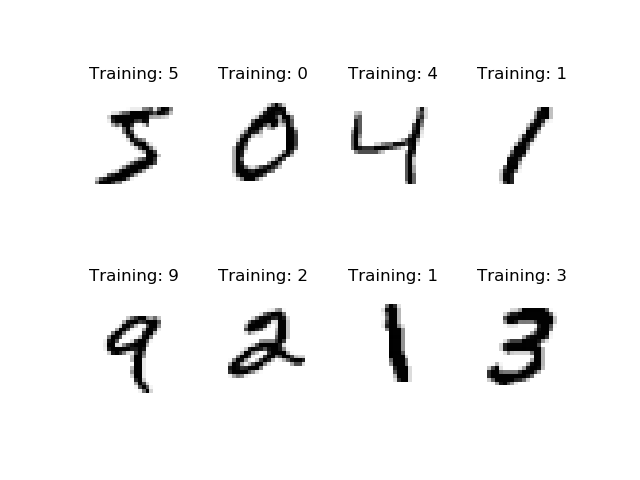

In [4]:
fig = plt.figure()
for i in range(8):
    ax = fig.add_subplot(2,4,i+1)
    ax.axis('off')
    ax.imshow(X_train[i], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title("Training: {}".format(y_train[i]))
plt.show()

# Preprocess the data <a class="anchor" id="preprocess"></a>

Before we can start to build and train our neural network, we first need to preprocess the data so that the keras framework can understand and interpret it

## Reshape and normalize image data <a class="anchor" id="reshape"></a>

"Typical" image data is RGB and would have a shape Nx28x28x3. This data is greyscale, so the shape needs to be Nx28x28x1. Our data is only Nx28x28, so we need to add an additional dimension for Keras to appropriately handle

We will alsoconvert to float32 and normalize the inputs to [0,1]. While this isn't strictly necessary, normalizing input data tends to improve performance

In [5]:
# reshape the data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
# cast to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize inputs
X_train /= 255
X_test /= 255

## Process the labels <a class="anchor" id="labels"></a>

As provided, the labels are directly associated with the data, i.e.

`y_train[9] = 4 # the 10th data point is an image of a "4"`

Because the output of our neural network will be 10 neurons, each associated with a digit, we need the labels to be categorized: rather than `y_train[9] = 4`, we need `y_train[9] = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]`

We use `np_utils.to_categorical` to achieve this

In [6]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# Flat Neural Network <a class="anchor" id="simple"></a>

Now we will define the architecture of our model. 

## Define model <a class="anchor" id="model"></a>

Let's start with an extremely simple Neural Net. Similar to the SVM example, we will operate on a flat array, so that

<IPython.core.display.Javascript object>


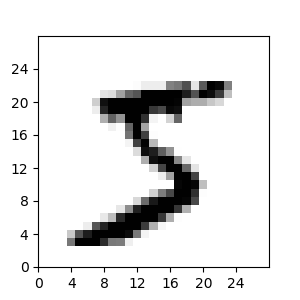

In [7]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
# ax.axis('off')
ax.imshow(np.flipud(X_train[0].reshape(28, 28)), cmap=plt.cm.gray_r,
          interpolation='nearest')
ax.set_xlim((0, 28))
ax.set_xticks([i for i in range(0, 28, 4)])
ax.set_ylim((0, 28))
ax.set_yticks([i for i in range(0, 28, 4)])
plt.show()

becomes

<IPython.core.display.Javascript object>


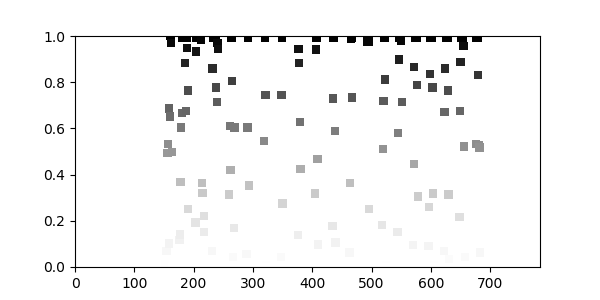

In [8]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
# ax.axis('off')
# ax.plot(X_train[0].reshape(-1))
ax.scatter(np.arange(X_train[0].shape[0]*X_train[0].shape[1]),
           X_train[0].reshape(-1), c=np.abs(X_train[0].reshape(-1)),
           cmap='Greys', edgecolor='none', marker='s',
           vmin=0, vmax=1)
ax.set_xlim((0, 28*28))
ax.set_ylim((0, 1))
plt.show()

### First Layer: Flat

We start with a flat input layer:

In [8]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))

### Second Layer: Dense

The second layer is a dense (fully connected) layer. We will only use 16 nodes. We will also use one of the simplest nonlinear activation functions, sigmoid.

**NOTE:** We are taking an input of $28*28=784$ nodes and piping those into only $16$ nodes. This is done on purpose to limit the effectiveness of the neural network for demonstration purposes.

In [9]:
model.add(Dense(16, activation='sigmoid'))

### Output Layer:

The final layer consists of 10 nodes, corresponding to the 10 different digits. We use the `softmax` activation funciton to force there only being a single node active for each set of data (this makes sense because each image can only be a single number

In [10]:
model.add(Dense(10, activation='softmax'))

### Compile model:

We need to set a few more parameters:

1. Loss function: this defines the function that will measure the performance of the neural network. Many loss functions are available. Because we are classifying (categorizing), we will use the `categorical_crossentropy` loss function
2. Optimizer: Defines the method the neural network will use to optimize its performance. We will use the simple `Stochastic Gradient Descent`
3. Metrics: `accuracy` is the basic metric, and it is all we will use here

In [11]:
model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=['accuracy'])

### Model Summary:

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


### Fit the model

Now, we will actually train the model! We specify the number of samples to be collected before updating the network weights (`batch_size`) and the number of times we iterate over the entire dataset (`epochs`).

In [13]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                    validation_split=0.2, shuffle=True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 3s 64us/step - loss: 1.9170 - acc: 0.5363 - val_loss: 1.5094 - val_acc: 0.7299
Epoch 2/100
48000/48000 [==============================] - 2s 41us/step - loss: 1.2502 - acc: 0.7549 - val_loss: 1.0115 - val_acc: 0.8106
Epoch 3/100
48000/48000 [==============================] - 2s 41us/step - loss: 0.9053 - acc: 0.8129 - val_loss: 0.7762 - val_acc: 0.8394
Epoch 4/100
48000/48000 [==============================] - 2s 42us/step - loss: 0.7326 - acc: 0.8383 - val_loss: 0.6483 - val_acc: 0.8622
Epoch 5/100
48000/48000 [==============================] - 2s 43us/step - loss: 0.6306 - acc: 0.8569 - val_loss: 0.5671 - val_acc: 0.8749
Epoch 6/100
48000/48000 [==============================] - 2s 42us/step - loss: 0.5623 - acc: 0.8698 - val_loss: 0.5107 - val_acc: 0.8849
Epoch 7/100
48000/48000 [==============================] - 2s 43us/step - loss: 0.5130 - acc: 0.8781 - val_loss: 0.4696 - 

## Evaluate model <a class="anchor" id="simple-evaluate"></a>

Let's consider the performance of the model

### Plot the training progress

Note that I continued to increase the number of epochs until I hit a plateau

<IPython.core.display.Javascript object>


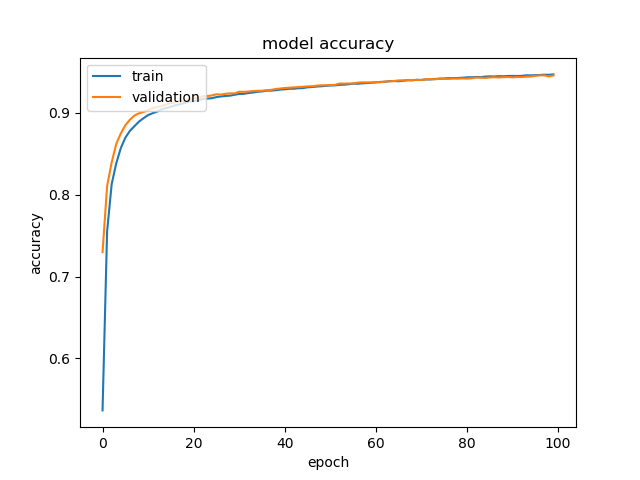

<IPython.core.display.Javascript object>


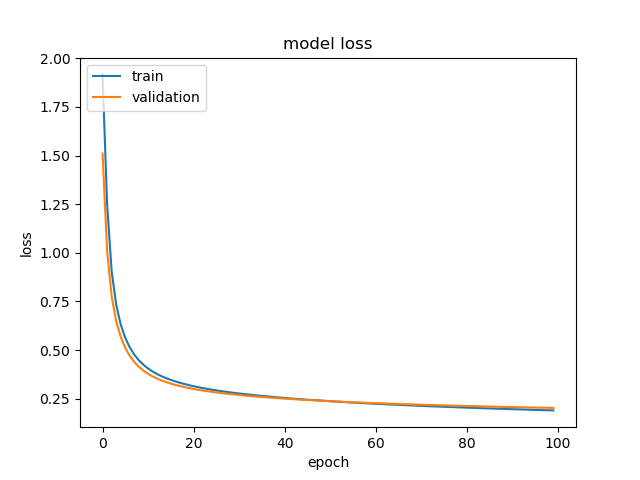

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

### Question:

Does the crossover of training and validation indicate overfitting?

In [15]:
score = model.evaluate(X_test, y_test)
print(f"loss = {score[0]}, accuracy={score[1]}")

10000/10000 [==============================] - 0s 20us/step
loss = 0.20429219291806222, accuracy=0.9422


### Analyze the confusion matrix

A nice way to understand and analyze the performance of a classification ML tool is a confusion matrix. Such a matrix displays the probability of accurately predicting a given category (diagonal), as well as incorrectly predicting a given category (off-diagonal)

<IPython.core.display.Javascript object>


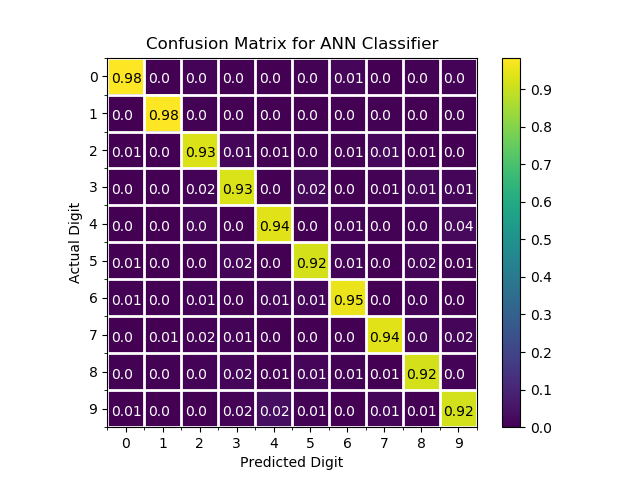

In [30]:
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

for i, j in ((x, y) for x in range(cm_norm.shape[1]) for y in range(cm_norm.shape[0])):
    if i != j:
        l_color = "white"
    else:
        l_color = "black"
    ax.annotate(str(np.round_(cm_norm[i,j], decimals=2)), xy=(i-0.4,j+0.2), color=l_color)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

## Summary <a class="anchor" id="simple-summary"></a>

Our very simple neural net has an overall accuracy of around 94% after 1000 epochs, detailed here

In [31]:
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fa6130fcf60>:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.93      0.94      1032
           3       0.92      0.93      0.93      1010
           4       0.94      0.94      0.94       982
           5       0.94      0.92      0.93       892
           6       0.94      0.95      0.95       958
           7       0.94      0.94      0.94      1028
           8       0.93      0.92      0.92       974
           9       0.93      0.92      0.92      1009

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000


Confusion matrix:
[[ 964    0    2    1    0    2    6    1    4    0]
 [   0 1115    3    4    0    2    4    2    5    0]
 [  10    4  961

Let's try to dig in a bit (see [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support) for more information)

#### Precision

Precision is $t_p \; / \; \left(t_p + f_p\right)$, the ratio of true positives to all predicted positives. This is the ability to avoid a false positive

#### Recall

Recall is $t_p \; / \; \left(t_p + f_n\right)$, the ratio of true positives to all values that should be positive. This is the ability to find the correct number of positives

#### F-score

f1-score is a weighted mean of the precision and recall. A perfect score is 1, and its worst is 0. This weighting can be adjusted with the `beta` parameter. `beta` defaults to 1, meaning recall and precision are equally important. This score will weight recall more than precision by a factor of `beta`

While we are alright overall, and better than the out-of-the-box SVM, we can do better

We also specify that we will have 32 filters to train i.e. 32 different "patterns" that will be learnt

## Flat improvement: ADAM optimizer <a class="anchor" id="simple-adam"></a>

### First, an example of overfitting

Notice how the testing starts to decline after approx. 20 epochs

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 1s 26us/step - loss: 0.8691 - acc: 0.8138 - val_loss: 0.4195 - val_acc: 0.9030
Epoch 2/100
48000/48000 [==============================] - 1s 23us/step - loss: 0.3676 - acc: 0.9058 - val_loss: 0.3053 - val_acc: 0.9188
Epoch 3/100
48000/48000 [==============================] - 1s 23us/step - loss: 0.2919 - acc: 0.9200 - val_loss: 0.2623 - val_acc: 0.9268
Epoch 4/100
48000/48000 [==============================] - 1s 23us/step - loss: 0.2568 - acc: 0.9277 - val_loss: 0.2418 - val_acc: 0.9317
Epoch 5/100
48000/48000 [==============================] - 1s 23us/step - loss: 0.2359 - acc: 0.9327 - val_loss: 0.2273 - val_acc: 0.9365
Epoch 6/100
48000/48000 [==============================] - 1s 24us/step - loss: 0.2203 - acc: 0.9372 - val_loss: 0.2178 - val_acc: 0.9383
Epoch 7/100
48000/48000 [==============================] - 1s 23us/step - loss: 0.2088 - acc: 0.9400 - val_loss: 0.2129 - 

<IPython.core.display.Javascript object>


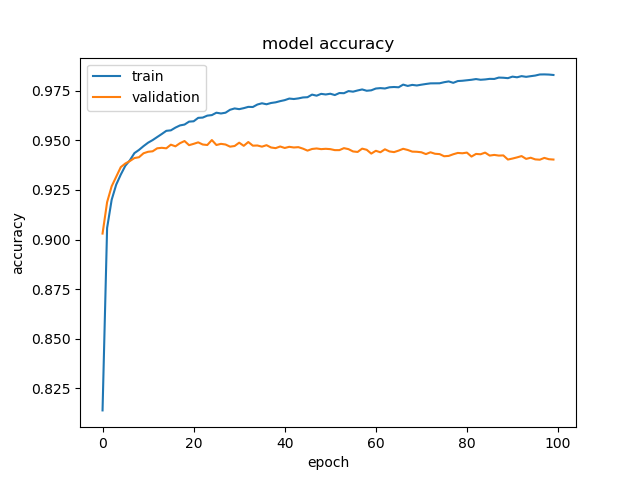

<IPython.core.display.Javascript object>


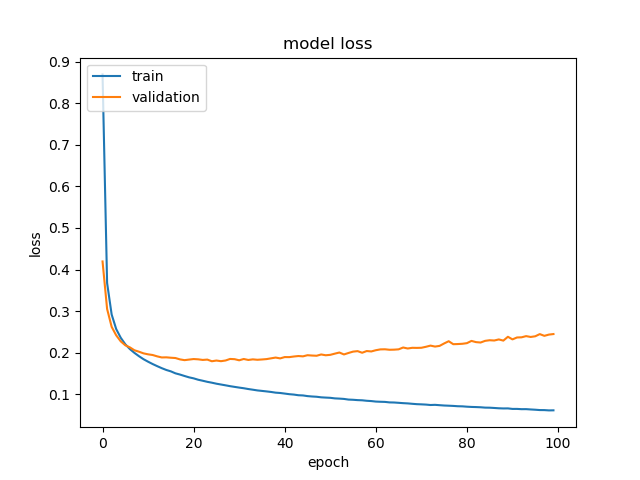

10000/10000 [==============================] - 0s 9us/step
[0.23977845682073384, 0.9412]


<IPython.core.display.Javascript object>


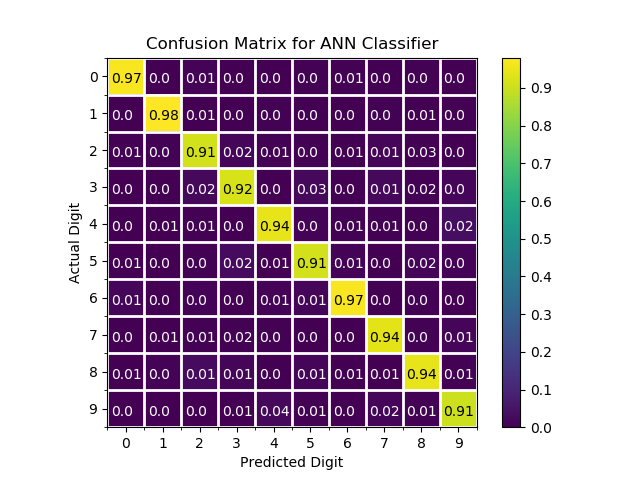

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fa604113cc0>:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.94      0.91      0.93      1032
           3       0.91      0.92      0.92      1010
           4       0.93      0.94      0.94       982
           5       0.92      0.91      0.92       892
           6       0.94      0.97      0.96       958
           7       0.95      0.94      0.95      1028
           8       0.91      0.94      0.93       974
           9       0.95      0.91      0.93      1009

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000


Confusion matrix:
[[ 952    0    5    3    3    0   13    1    3    0]
 [   0 1113    7    1    0    0    3    1   10    0]
 [   9    3  944

In [33]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))
# model.add(Dense(28*28, activation='relu'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                    validation_split=0.2, shuffle=True)
model.summary()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

for i, j in ((x, y) for x in range(cm_norm.shape[1]) for y in range(cm_norm.shape[0])):
    if i != j:
        l_color = "white"
    else:
        l_color = "black"
    ax.annotate(str(np.round_(cm_norm[i,j], decimals=2)), xy=(i-0.4,j+0.2), color=l_color)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

### Avoid overfitting

Use early stopping

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 1s 28us/step - loss: 0.9002 - acc: 0.8041 - val_loss: 0.4447 - val_acc: 0.9008
Epoch 2/100
48000/48000 [==============================] - 1s 24us/step - loss: 0.3838 - acc: 0.9029 - val_loss: 0.3134 - val_acc: 0.9181
Epoch 3/100
48000/48000 [==============================] - 1s 24us/step - loss: 0.3014 - acc: 0.9182 - val_loss: 0.2727 - val_acc: 0.9266
Epoch 4/100
48000/48000 [==============================] - 1s 24us/step - loss: 0.2649 - acc: 0.9255 - val_loss: 0.2542 - val_acc: 0.9306
Epoch 5/100
48000/48000 [==============================] - 1s 25us/step - loss: 0.2421 - acc: 0.9321 - val_loss: 0.2360 - val_acc: 0.9345
Epoch 6/100
48000/48000 [==============================] - 1s 24us/step - loss: 0.2264 - acc: 0.9358 - val_loss: 0.2260 - val_acc: 0.9374
Epoch 7/100
48000/48000 [==============================] - 1s 23us/step - loss: 0.2153 - acc: 0.9394 - val_loss: 0.2181 - 

<IPython.core.display.Javascript object>


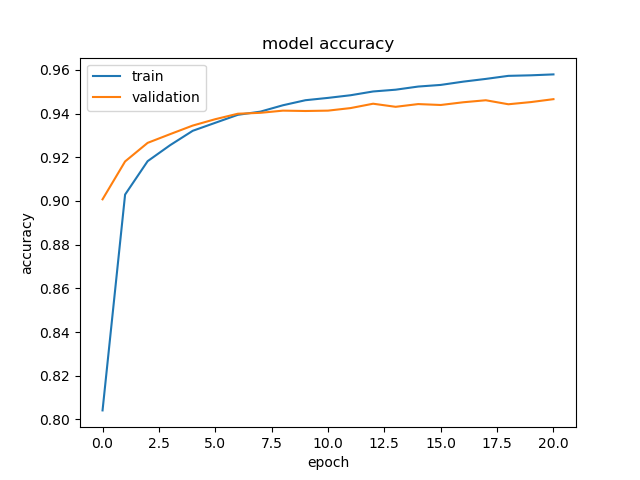

<IPython.core.display.Javascript object>


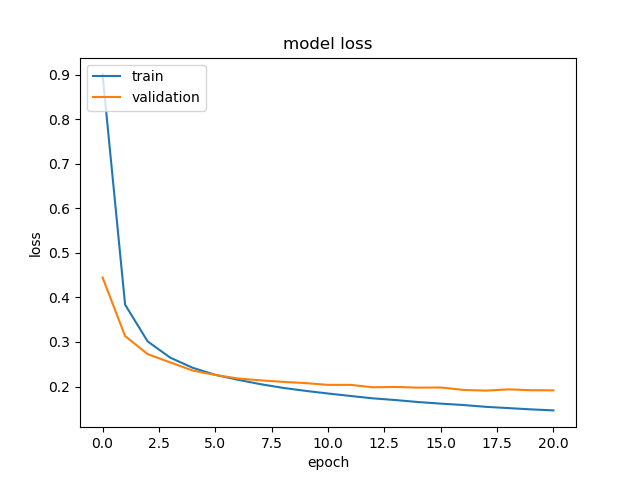

10000/10000 [==============================] - 0s 9us/step
[0.19261997017264365, 0.9445]


<IPython.core.display.Javascript object>


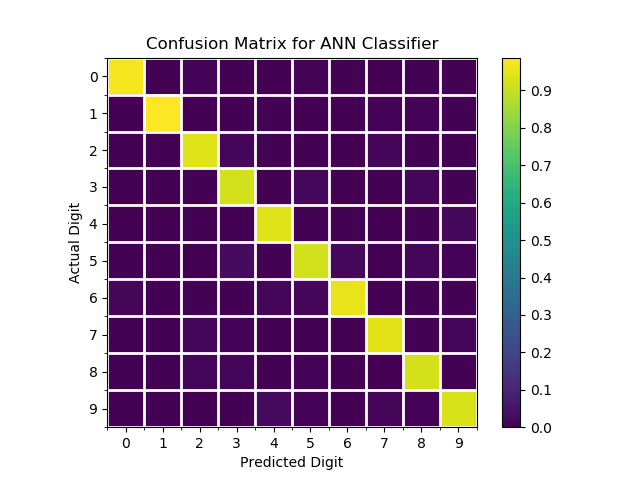

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fa6040d9a20>:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.94      0.94      0.94      1032
           3       0.95      0.92      0.93      1010
           4       0.95      0.94      0.94       982
           5       0.91      0.92      0.91       892
           6       0.94      0.96      0.95       958
           7       0.95      0.95      0.95      1028
           8       0.93      0.93      0.93       974
           9       0.93      0.93      0.93      1009

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000


Confusion matrix:
[[ 953    0    3    1    2    4   12    0    3    2]
 [   0 1121    5    0    0    2    2    1    4    0]
 [   8    1  971

In [34]:

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1)
model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))
# model.add(Dense(28*28, activation='relu'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                    validation_split=0.2, shuffle=True, callbacks=[early_stop])
model.summary()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

While the overall accuracy in the model improves a little bit $0.94 \to 0.95$, we see quite an improvement in training time by using the Adam optimizer (1/4 of the epochs = 4x faster).

Can we do better using more nodes?

## More flat improvements: Increase number of second layer nodes <a class="anchor" id="flat-dense"></a>

Lets use 64

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 2s 39us/step - loss: 0.5119 - acc: 0.8796 - val_loss: 0.2611 - val_acc: 0.9297
Epoch 2/100
48000/48000 [==============================] - 2s 38us/step - loss: 0.2387 - acc: 0.9329 - val_loss: 0.2030 - val_acc: 0.9429
Epoch 3/100
48000/48000 [==============================] - 2s 46us/step - loss: 0.1866 - acc: 0.9464 - val_loss: 0.1729 - val_acc: 0.9522
Epoch 4/100
48000/48000 [==============================] - 2s 38us/step - loss: 0.1551 - acc: 0.9560 - val_loss: 0.1564 - val_acc: 0.9561
Epoch 5/100
48000/48000 [==============================] - 2s 41us/step - loss: 0.1328 - acc: 0.9621 - val_loss: 0.1408 - val_acc: 0.9599
Epoch 6/100
48000/48000 [==============================] - 2s 40us/step - loss: 0.1155 - acc: 0.9671 - val_loss: 0.1301 - val_acc: 0.9648
Epoch 7/100
48000/48000 [==============================] - 2s 42us/step - loss: 0.1019 - acc: 0.9713 - val_loss: 0.1257 - 

<IPython.core.display.Javascript object>


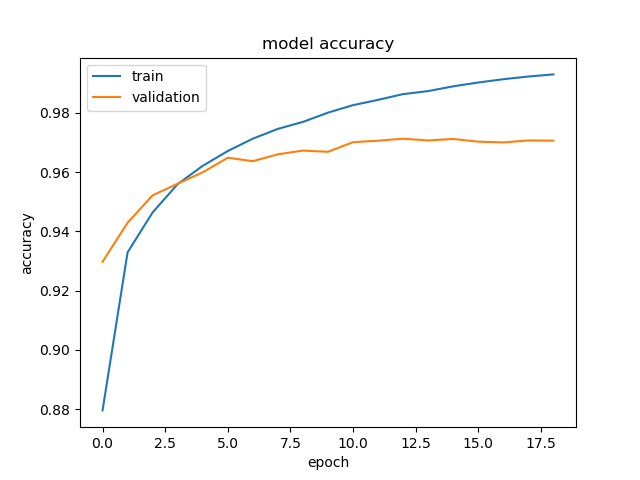

<IPython.core.display.Javascript object>


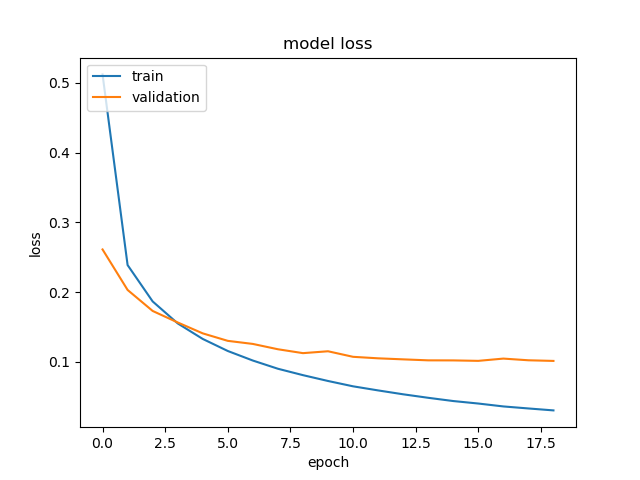

10000/10000 [==============================] - 0s 14us/step
[0.09160591517440043, 0.9721]


<IPython.core.display.Javascript object>


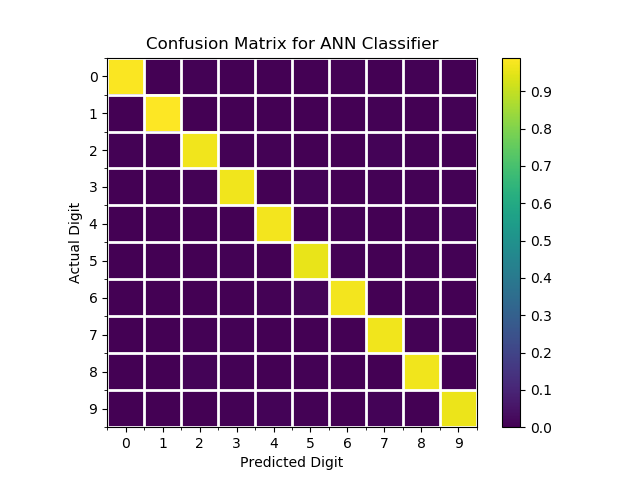

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fa5ac645b00>:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.97      0.96      0.96       892
           6       0.97      0.97      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.96      0.97      0.97       974
           9       0.97      0.96      0.97      1009

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


Confusion matrix:
[[ 966    0    4    2    0    1    3    2    2    0]
 [   0 1124    3    1    0    0    3    0    4    0]
 [   5    3  999

In [35]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                    validation_split=0.2, shuffle=True, callbacks=[early_stop])
model.summary()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

We are now up to 97% accuracy in 14 epochs!

That's very impressive...but we can do much better with a convolutional model

# Simple Convolutional Model <a class="anchor" id="conv-simple"></a>

Let's start with a very simple convolutional model:

1. Convolutional Layer to handle the image
2. Output Layer

## Convolution Animation <a class="anchor" id="conv-ani"></a>

We will be using a multi-layer neural net to learn handwritten digits. Because the input images are 2D, and because of their relative strength in learning images, we will use convolutional layers to learn our model.

By passing a 3x3 kernel over the 28x28 image, we end up with an output image of 26x26 (see how this results below)

<IPython.core.display.Javascript object>


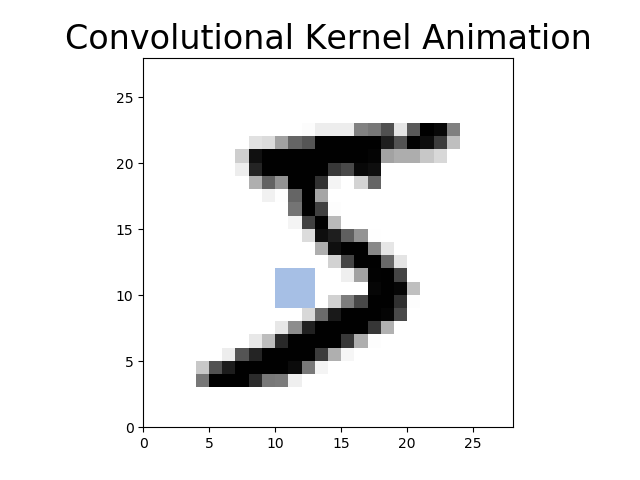

In [39]:
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111)
im_arr = X_train[0].reshape(28, 28)
ax.imshow(im_arr, extent=(0, 28, 0, 28), cmap=plt.cm.gray_r, vmin=0, vmax=1)
ax.set_title("Convolutional Kernel Animation", fontsize=24)
kernel_arr = np.zeros((28, 28, 4))
kernel_arr[:3, :3, :] = [0.3, 0.5, 0.8, 0.5]
im = ax.imshow(kernel_arr, extent=(0, 28, 0, 28), vmin=0, vmax=1)

ani_i = 0
ani_j = 0

def updatefig(*args):
    global im_arr, ax
    global ani_i, ani_j
    # increment j
    ani_j += 1
    # increment i once j resets
    ani_i = ani_i + 1 if (ani_j%26 == 0) else ani_i
    # handle periodic boundaries
    ani_j = ani_j % 26
    ani_i = ani_i % 26
    kernel_arr = np.zeros((28, 28, 4))
    kernel_arr[ani_i:ani_i+3, ani_j:ani_j+3, :] = [0.3, 0.5, 0.8, 0.5]
    im.set_array(kernel_arr)
    return im,

# display animation
ani = animation.FuncAnimation(fig, updatefig, blit=True, interval=20, repeat=True)
ax.set_xlim((0, 28))
ax.set_ylim((0, 28))
plt.show()

### Sigmoid Activation

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 3s 72us/step - loss: 9.9216 - acc: 0.3332 - val_loss: 9.8030 - val_acc: 0.3729
Epoch 2/100
48000/48000 [==============================] - 3s 65us/step - loss: 9.8270 - acc: 0.3692 - val_loss: 9.8145 - val_acc: 0.3742
Epoch 3/100
48000/48000 [==============================] - 3s 66us/step - loss: 9.8159 - acc: 0.3737 - val_loss: 9.7803 - val_acc: 0.3812
Epoch 4/100
48000/48000 [==============================] - 3s 65us/step - loss: 9.8017 - acc: 0.3756 - val_loss: 9.7804 - val_acc: 0.3797
Epoch 5/100
48000/48000 [==============================] - 3s 65us/step - loss: 9.7966 - acc: 0.3766 - val_loss: 9.7823 - val_acc: 0.3777
Epoch 6/100
48000/48000 [==============================] - 3s 67us/step - loss: 9.7814 - acc: 0.3795 - val_loss: 9.7535 - val_acc: 0.3866
Epoch 7/100
48000/48000 [==============================] - 3s 65us/step - loss: 9.7634 - acc: 0.3831 - val_loss: 9.7694 - 

<IPython.core.display.Javascript object>


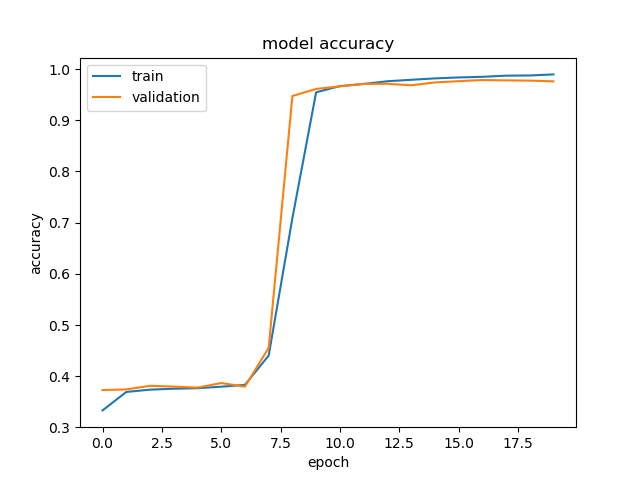

<IPython.core.display.Javascript object>


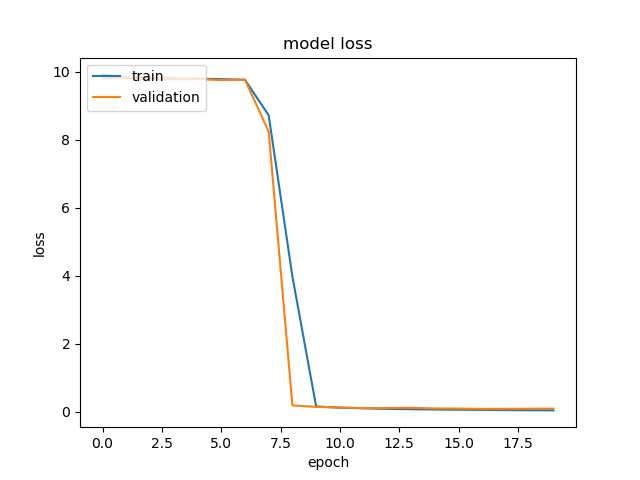

10000/10000 [==============================] - 0s 29us/step
[0.07410266082277521, 0.9773]


<IPython.core.display.Javascript object>


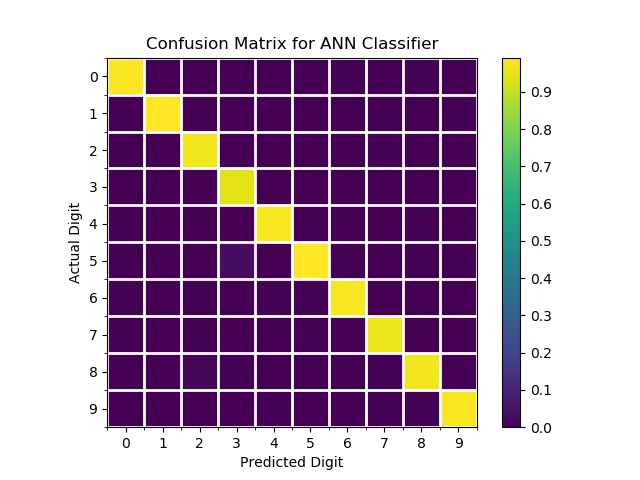

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7f2d5839ef98>:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.99      0.95      0.97      1010
           4       0.99      0.98      0.98       982
           5       0.94      0.99      0.96       892
           6       0.97      0.98      0.98       958
           7       0.99      0.97      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.98      0.98      1009

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


Confusion matrix:
[[ 968    0    2    0    0    3    5    1    1    0]
 [   0 1126    0    1    1    2    3    0    2    0]
 [   3    4 1000

In [25]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                    validation_split=0.2, shuffle=True, callbacks=[early_stop])
model.summary()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

### tanh activation

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 3s 73us/step - loss: 0.3631 - acc: 0.8960 - val_loss: 0.2902 - val_acc: 0.9204
Epoch 2/100
48000/48000 [==============================] - 3s 65us/step - loss: 0.3050 - acc: 0.9132 - val_loss: 0.2879 - val_acc: 0.9203
Epoch 3/100
48000/48000 [==============================] - 3s 66us/step - loss: 0.2891 - acc: 0.9184 - val_loss: 0.2753 - val_acc: 0.9239
Epoch 4/100
48000/48000 [==============================] - 3s 66us/step - loss: 0.2723 - acc: 0.9229 - val_loss: 0.2770 - val_acc: 0.9204
Epoch 5/100
48000/48000 [==============================] - 3s 68us/step - loss: 0.2552 - acc: 0.9274 - val_loss: 0.2614 - val_acc: 0.9283
Epoch 6/100
48000/48000 [==============================] - 3s 67us/step - loss: 0.2363 - acc: 0.9320 - val_loss: 0.2453 - val_acc: 0.9336
Epoch 7/100
48000/48000 [==============================] - 3s 66us/step - loss: 0.2228 - acc: 0.9364 - val_loss: 0.2481 - 

<IPython.core.display.Javascript object>


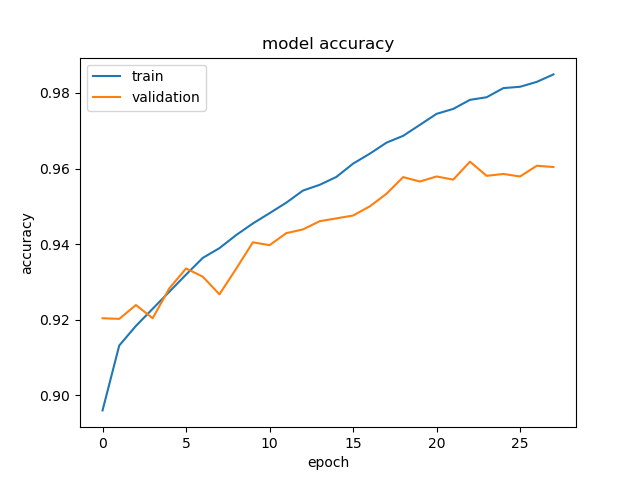

<IPython.core.display.Javascript object>


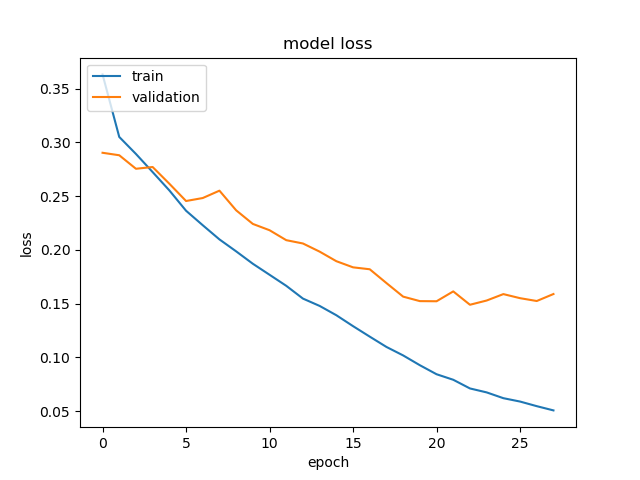

10000/10000 [==============================] - 0s 29us/step
[0.15869283981304616, 0.9588]


<IPython.core.display.Javascript object>


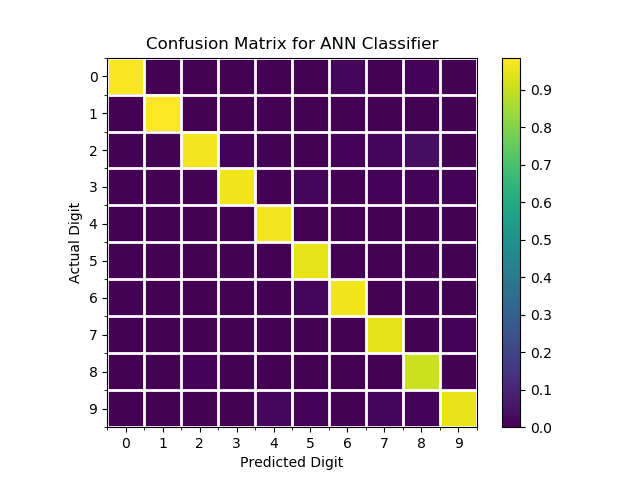

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7f2dc81b5cf8>:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.91      0.97      0.94      1032
           3       0.95      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.95      0.96       892
           6       0.97      0.96      0.97       958
           7       0.97      0.94      0.96      1028
           8       0.96      0.91      0.93       974
           9       0.94      0.95      0.95      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


Confusion matrix:
[[ 961    0    6    0    2    2    5    1    3    0]
 [   0 1118    5    1    0    0    1    1    8    1]
 [   1    7  999

In [26]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), activation='tanh', input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5, verbose=1)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                    validation_split=0.2, shuffle=True, callbacks=[early_stop])
model.summary()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

### relu activation

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 3s 72us/step - loss: 0.1940 - acc: 0.9426 - val_loss: 0.0977 - val_acc: 0.9734
Epoch 2/100
48000/48000 [==============================] - 3s 73us/step - loss: 0.0723 - acc: 0.9784 - val_loss: 0.0850 - val_acc: 0.9750
Epoch 3/100
48000/48000 [==============================] - 3s 68us/step - loss: 0.0513 - acc: 0.9837 - val_loss: 0.0778 - val_acc: 0.9782
Epoch 4/100
48000/48000 [==============================] - 3s 73us/step - loss: 0.0382 - acc: 0.9882 - val_loss: 0.0803 - val_acc: 0.9778
Epoch 5/100
48000/48000 [==============================] - 3s 73us/step - loss: 0.0299 - acc: 0.9904 - val_loss: 0.0755 - val_acc: 0.9799
Epoch 6/100
48000/48000 [==============================] - 3s 66us/step - loss: 0.0220 - acc: 0.9929 - val_loss: 0.0835 - val_acc: 0.9791
Epoch 7/100
48000/48000 [==============================] - 3s 68us/step - loss: 0.0172 - acc: 0.9948 - val_loss: 0.0923 - 

<IPython.core.display.Javascript object>


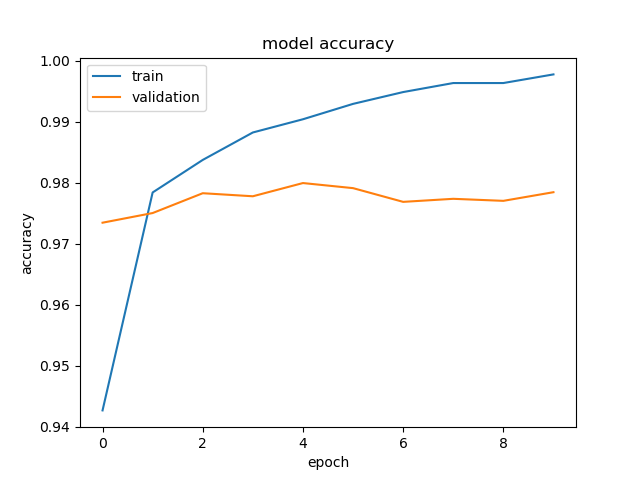

<IPython.core.display.Javascript object>


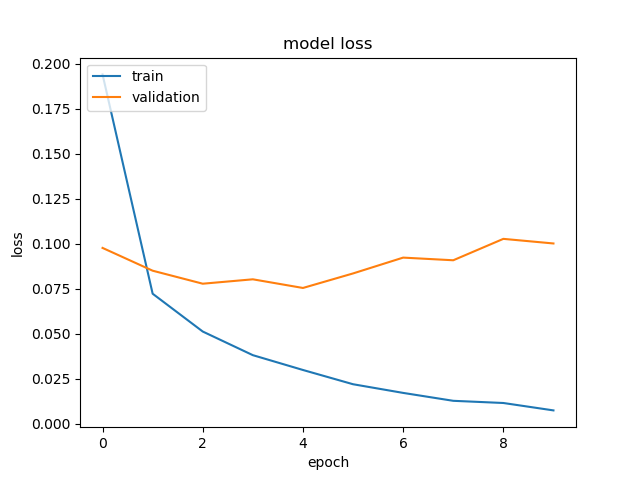

10000/10000 [==============================] - 0s 28us/step
[0.085833394788031, 0.9814]


<IPython.core.display.Javascript object>


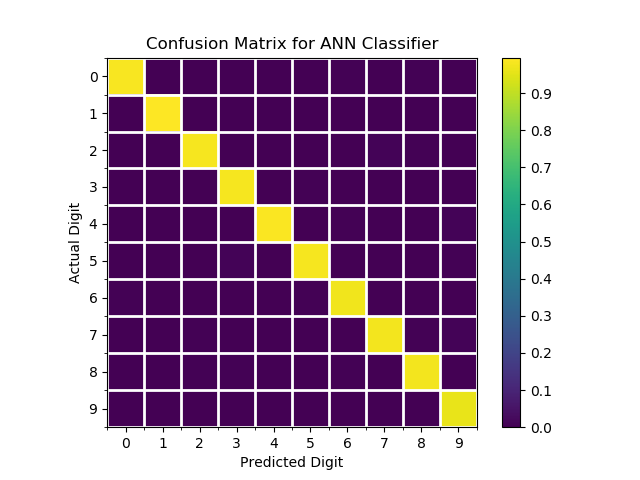

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7f2ba6212f60>:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      1.00      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.98      0.98       974
           9       0.99      0.96      0.98      1009

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


Confusion matrix:
[[ 967    0    3    1    1    1    4    0    3    0]
 [   0 1130    4    0    0    0    0    1    0    0]
 [   1    2 1013

In [27]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5, verbose=1)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                    validation_split=0.2, shuffle=True, callbacks=[early_stop])
model.summary()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

### leaky relu

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 4s 92us/step - loss: 0.2810 - acc: 0.9194 - val_loss: 0.1536 - val_acc: 0.9588
Epoch 2/100
48000/48000 [==============================] - 4s 85us/step - loss: 0.1293 - acc: 0.9628 - val_loss: 0.1264 - val_acc: 0.9624
Epoch 3/100
48000/48000 [==============================] - 4s 84us/step - loss: 0.0955 - acc: 0.9718 - val_loss: 0.1041 - val_acc: 0.9720
Epoch 4/100
48000/48000 [==============================] - 4s 82us/step - loss: 0.0771 - acc: 0.9764 - val_loss: 0.0957 - val_acc: 0.9752
Epoch 5/100
48000/48000 [==============================] - 4s 87us/step - loss: 0.0634 - acc: 0.9805 - val_loss: 0.0985 - val_acc: 0.9722
Epoch 6/100
48000/48000 [==============================] - 4s 84us/step - loss: 0.0574 - acc: 0.9820 - val_loss: 0.0947 - val_acc: 0.9746
Epoch 7/100
48000/48000 [==============================] - 4s 85us/step - loss: 0.0483 - acc: 0.9850 - val_loss: 0.0975 - 

<IPython.core.display.Javascript object>


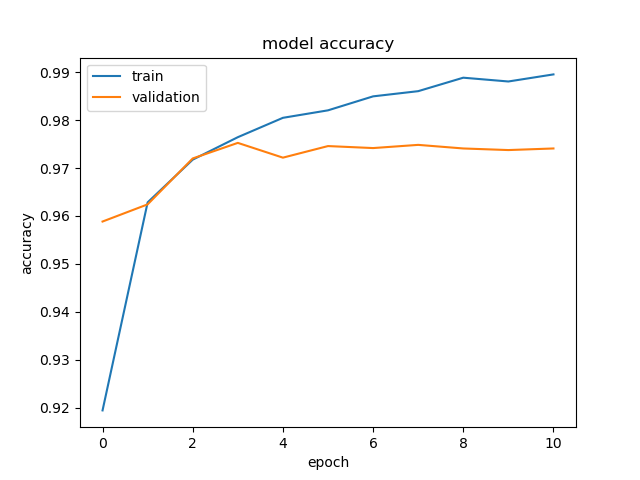

<IPython.core.display.Javascript object>


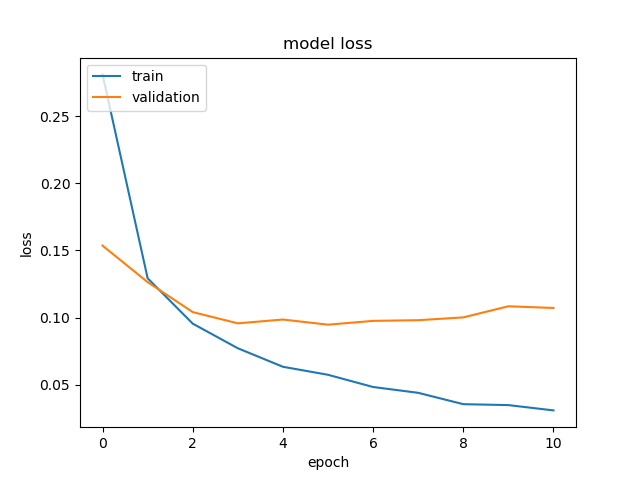

10000/10000 [==============================] - 0s 33us/step
[0.09936573145005387, 0.9732]


<IPython.core.display.Javascript object>


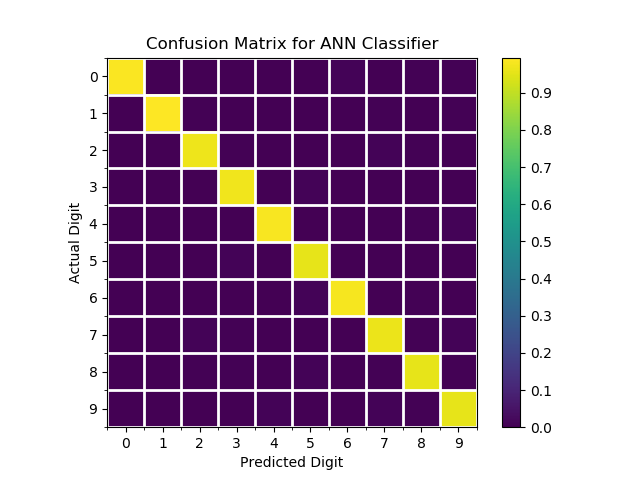

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7f2ba5a4c208>:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.97      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.96      1028
           8       0.96      0.96      0.96       974
           9       0.97      0.96      0.96      1009

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


Confusion matrix:
[[ 971    1    2    0    1    0    2    1    2    0]
 [   0 1129    2    0    1    0    1    1    1    0]
 [   3    7 1000

In [28]:
from keras.layers import LeakyReLU
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(28, 28, 1)))
# note you need to add as a layer, not as an activation to a layer
model.add(LeakyReLU())
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5, verbose=1)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                    validation_split=0.2, shuffle=True, callbacks=[early_stop])
model.summary()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

### Comparison

| Activation |  Score | N_Epochs |
|:-----------|--------|----------|
|   Sigmoid  | 0.9791 |    20    |
|    TanH    | 0.9388 |    18    |
|    ReLU    | 0.9805 |     7    |
| Leaky ReLU | 0.9732 |     8    |

# Mulit-layer Convolutional Neural Network <a class="anchor" id="conv-multi"></a>

Now let's improve with more layers...not like actually needs to be improved 

In [40]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

## Add more layers

We'll add yet another convolutional layer. Then, we'll have a 2x2 kernel pass over the previous layer, taking the max of the 4 values. Finally, a dropout layer will be added to accelerate back-propogation of weights and help prevent overfitting. Very briefly, dropout helps improve training by periodically deactivating neurons during training, preventing two neurons from effectively blindly passing values along without taking the activation of other connecting neurons into account

In [41]:
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

## Complete the network

We now flatten the network into a single dimension, add a fully connected layer, and then our output layer. Because we are classifying, the final layer will have as many nodes as our classes (10). We use the `softmax` activation function to enforce that only one node activates in the output layer

In [42]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model

Declare the loss function, optimizer, etc.

In [43]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

## Train the network/Fit the data

Train the network and save; training takes O(10 min) on a CPU, and O(2 min) on a GPU.

In [44]:
# load the data
load = False
if not (os.path.exists("keras_mnist_ann.h5") and os.path.exists("keras_mnist_ann.json") and load):
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5, verbose=1)

    history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                        validation_split=0.2, shuffle=True, callbacks=[early_stop])
    # save model
    model_json = model.to_json()
    with open("keras_mnist_ann.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("keras_mnist_ann.h5")
else:
    json_file = open("keras_mnist_ann.json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = keras.models.model_from_json(loaded_model_json)
    model.load_weights("keras_mnist_ann.h5")
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 42s 875us/step - loss: 0.2442 - acc: 0.9262 - val_loss: 0.0597 - val_acc: 0.9832
Epoch 2/100
48000/48000 [==============================] - 41s 857us/step - loss: 0.0965 - acc: 0.9713 - val_loss: 0.0475 - val_acc: 0.9851
Epoch 3/100
48000/48000 [==============================] - 41s 847us/step - loss: 0.0734 - acc: 0.9775 - val_loss: 0.0426 - val_acc: 0.9877
Epoch 4/100
48000/48000 [==============================] - 41s 850us/step - loss: 0.0617 - acc: 0.9815 - val_loss: 0.0420 - val_acc: 0.9883
Epoch 5/100
48000/48000 [==============================] - 43s 896us/step - loss: 0.0520 - acc: 0.9843 - val_loss: 0.0433 - val_acc: 0.9882
Epoch 6/100
48000/48000 [==============================] - 44s 917us/step - loss: 0.0459 - acc: 0.9859 - val_loss: 0.0430 - val_acc: 0.9883
Epoch 7/100
48000/48000 [==============================] - 43s 892us/step - loss: 0.0389 - acc: 0.9877 - val_l

# Evaluate model on test data

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               589952    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

<IPython.core.display.Javascript object>


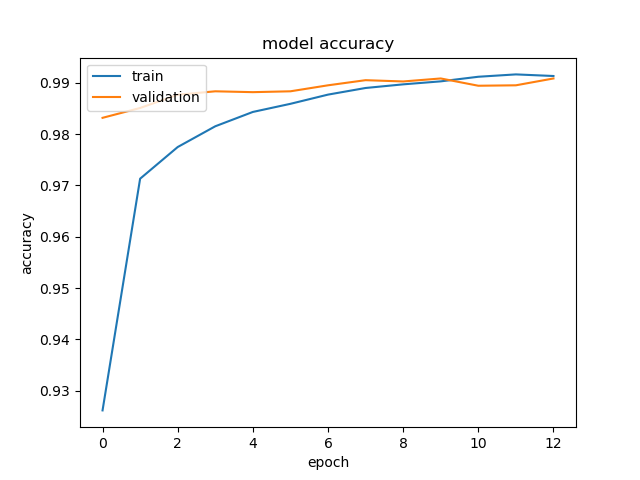

<IPython.core.display.Javascript object>


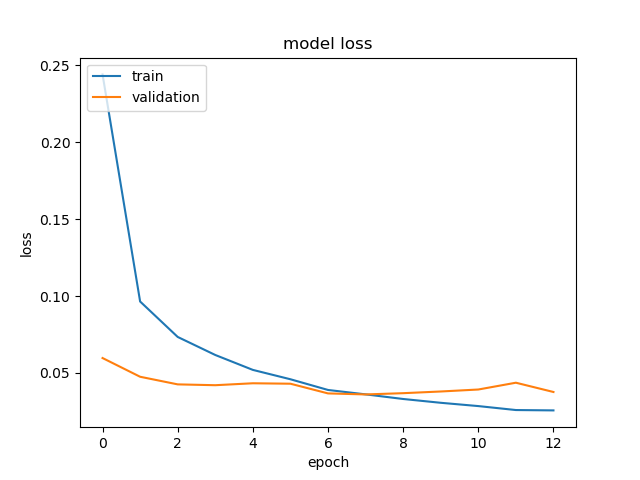

In [45]:
model.summary()
score = model.evaluate(X_test, y_test)
print(score)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

# View Confusion Matrix

<IPython.core.display.Javascript object>


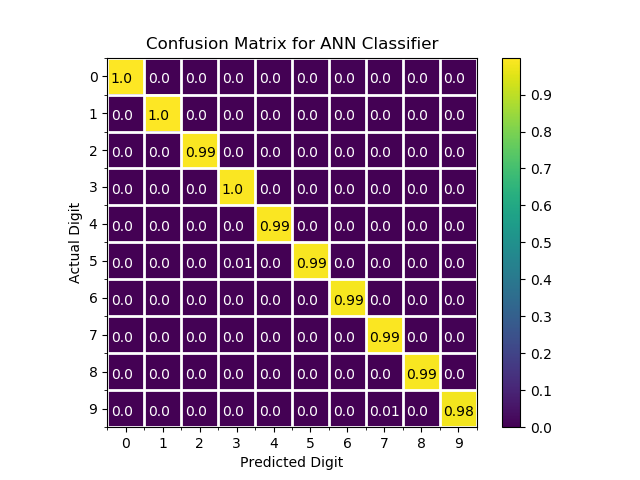

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fa5a5e00128>:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

   micro avg       0.99      0.99      0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


Confusion matrix:
[[ 979    0    0    0    0    0    0    1    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   1    0 1024

In [46]:
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

for i, j in ((x, y) for x in range(cm_norm.shape[1]) for y in range(cm_norm.shape[0])):
    if i != j:
        l_color = "white"
    else:
        l_color = "black"
    ax.annotate(str(np.round_(cm_norm[i,j], decimals=2)), xy=(i-0.4,j+0.2), color=l_color)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

# Summary <a class="anchor" id="summary"></a>

|    Network   | Accuracy | n_epochs |
|--------------|----------|---------:|
|   Flat-SGD   |  0.9392  |    100   |
|   Flat-ADAM  |  0.9485  |    25    |
|  Flat-Dense  |  0.9724  |    15    |
| Conv-Sigmoid |  0.9791  |    20    |
|   Conv-tanh  |  0.9388  |    18    |
|   Conv-ReLU  |  0.9805  |     7    |
|  Conv-LReLU  |  0.9732  |     8    |
|  Conv-Multi  |  0.9919  |    15    |


Compare to SVM/SVC performance:

| SVM | Accuracy |
| ------------- |-----:|
| SVC | 0.8883 |

# Visualizing the Neural Network layers

Artificial neural networks are often referred to as "black boxes" because the weighting and outputs of the layers are not easy to view (and as we will see, are not necessarily easy to inuit/interpret when we can).

Here we create another neural net, this time with 3 convolutional layers before a maxpooling layer. We will then view the output of each layer after training when supplied with an image.

In [7]:
model = Sequential()

model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
convout1 = Activation('relu')
model.add(convout1)

model.add(Convolution2D(32, (3, 3), activation='relu'))
convout2 = Activation('relu')
model.add(convout2)

model.add(Convolution2D(32, (3, 3), activation='relu'))
convout3 = Activation('relu')
model.add(convout3)

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
maxout = Activation('relu')
model.add(maxout)

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, nb_epoch=10, validation_data=(X_test, y_test))

model.summary()
score = model.evaluate(X_test, y_test)
print(score)

y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 93us/step - loss: 0.2619 - acc: 0.9204 - val_loss: 0.0569 - val_acc: 0.9816
Epoch 2/10
60000/60000 [==============================] - 4s 70us/step - loss: 0.0895 - acc: 0.9736 - val_loss: 0.0394 - val_acc: 0.9873
Epoch 3/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.0686 - acc: 0.9788 - val_loss: 0.0327 - val_acc: 0.9888
Epoch 4/10
60000/60000 [==============================] - 4s 71us/step - loss: 0.0572 - acc: 0.9827 - val_loss: 0.0286 - val_acc: 0.9905
Epoch 5/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.0492 - acc: 0.9849 - val_loss: 0.0303 - val_acc: 0.9899
Epoch 6/10
60000/60000 [==============================] - 4s 68us/step - loss: 0.0412 - acc: 0.9876 - val_loss: 0.0286 - val_acc: 0.9915
Epoch 7/10
60000/60000 [==============================] - 4s 70us/step - loss: 0.0374 - acc: 0.9880 - val_loss: 0.0287 - val_acc

In [8]:
# choose any image to want by specifying the index
img_to_visualize = X_train[13]
# Keras requires the image to be in 4D
# So we add an extra dimension to it.
img_to_visualize = np.expand_dims(img_to_visualize, axis=0)

def layer_to_visualize(layer, my_title):
    """
    compute the output of the convolutional and maxpool layers
    
    requires the use of particular backend flags to turn off
    training behavior
    """
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    # compute the convolutional output of the layer given
    # the input image
    # e.g. The first layer will take a 28x28 image and will use
    # a Convolution2D layer to pass a 3x3 kernel to create 32 filters
    # meaning 1 28x28x1 image becomes 32 26x26x1 images
    convolutions = convout1_f(img_to_visualize)
    # use the squeeze function dump the channel data
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    # technically this is "backward" from the original example
    # this is because we are using a slightly different API to
    # pass our images into the network
    n = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(convolutions.shape[2]):
        ax = fig.add_subplot(n,n,i+1)
        ax.axis('off')
        ax.imshow(convolutions[:,:,i], cmap='gray')
    fig.suptitle(my_title, fontsize=24)

Shape of conv: (26, 26, 32)


<IPython.core.display.Javascript object>


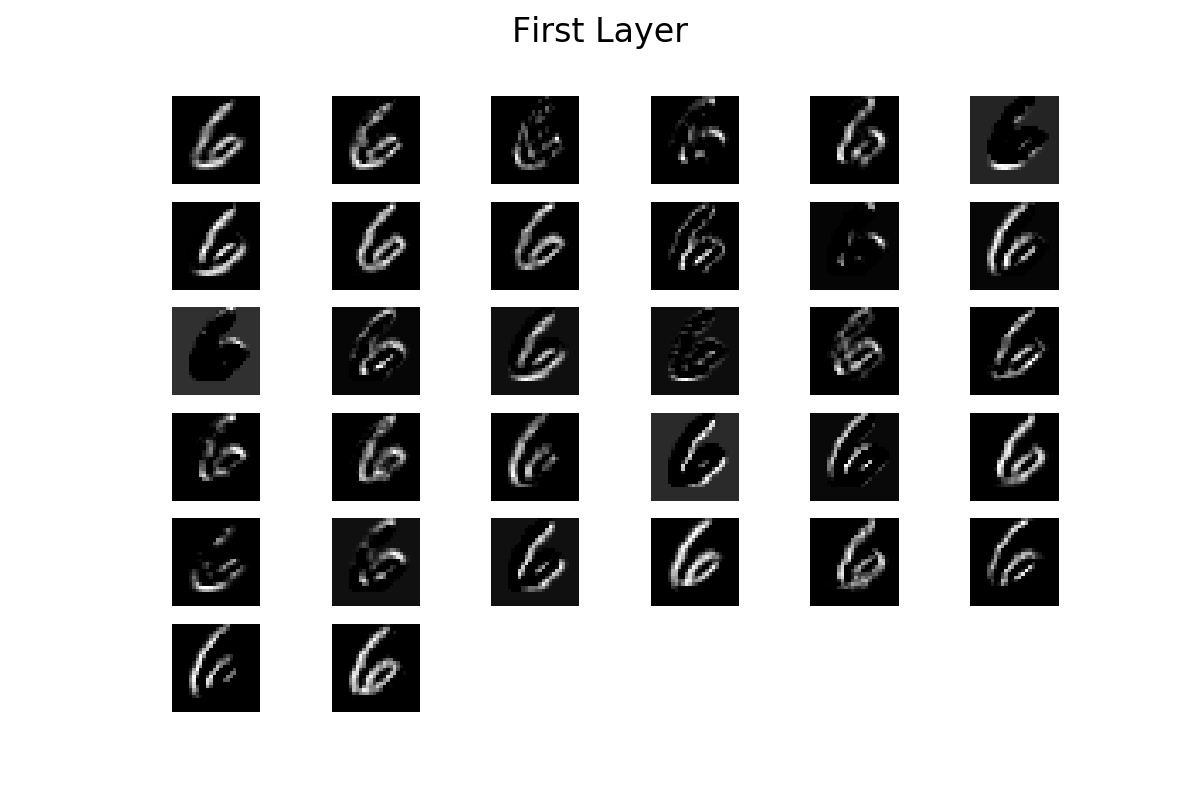

Shape of conv: (24, 24, 32)


<IPython.core.display.Javascript object>


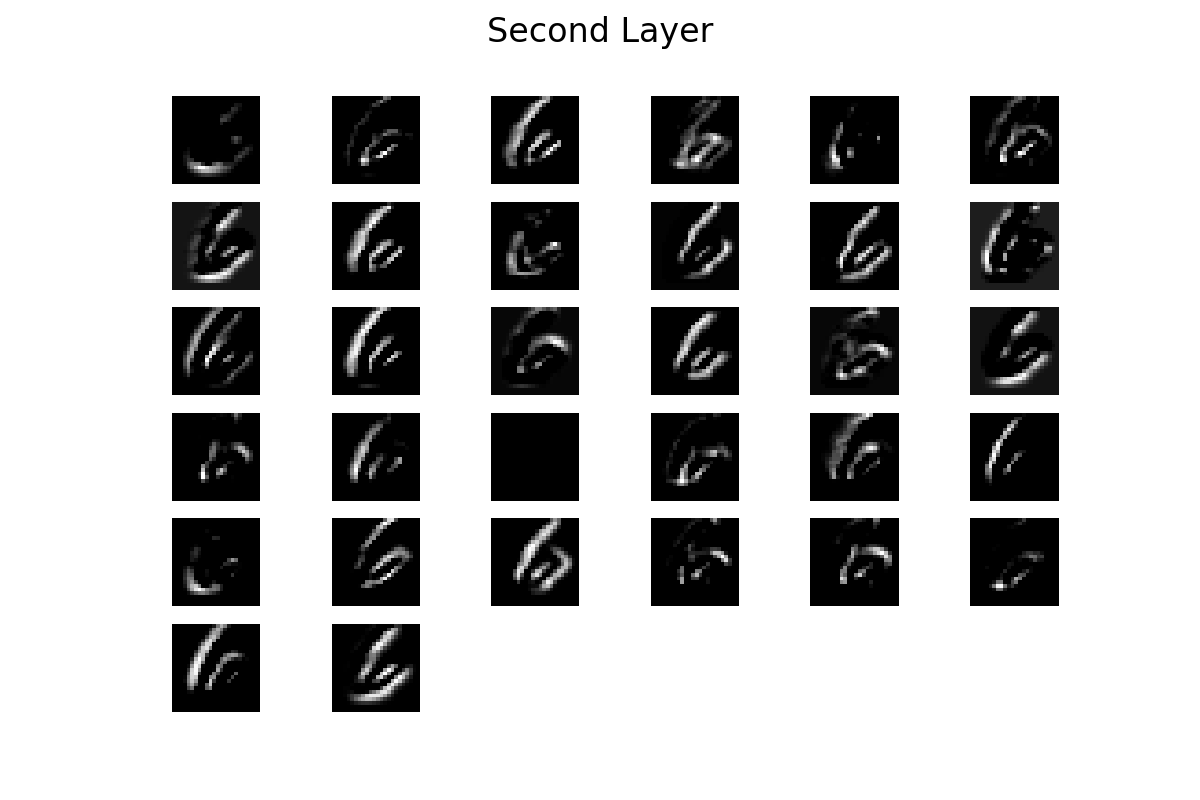

Shape of conv: (22, 22, 32)


<IPython.core.display.Javascript object>


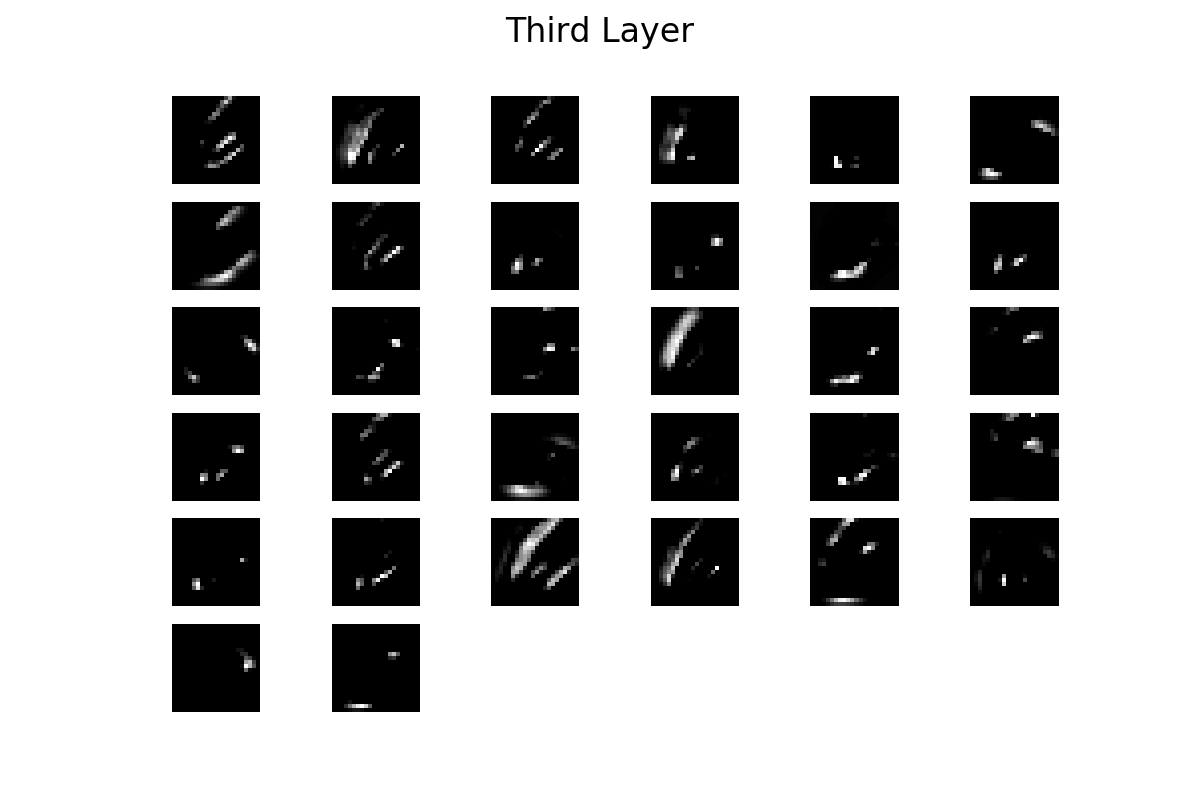

Shape of conv: (11, 11, 32)


<IPython.core.display.Javascript object>


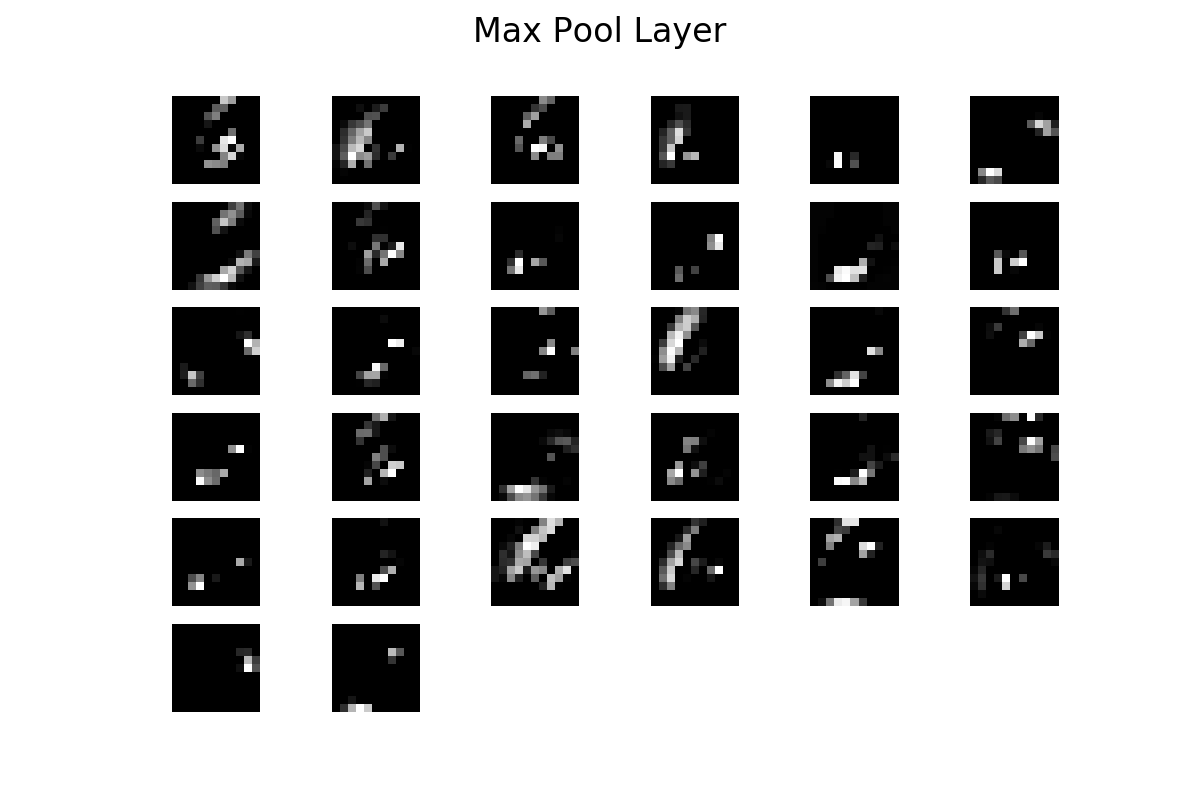

In [9]:
# Specify the layer to want to visualize
layer_to_visualize(convout1, "First Layer")

# # As convout2 is the result of a MaxPool2D layer
# # We can see that the image has blurred since
# # the resolution has reduced 
layer_to_visualize(convout2, "Second Layer")

layer_to_visualize(convout3, "Third Layer")

layer_to_visualize(maxout, "Max Pool Layer")



## Deeper example

[Adapted from kaggle notebook](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook)

In [12]:
model = Sequential()

# note the padding argument here keeps the image size the same...and prevents the shrinking
# also note the larger kernel
model.add(Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
convout2 = Activation('relu')
model.add(convout2)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Convolution2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
convout3 = Activation('relu')
model.add(convout3)
model.add(Convolution2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
convout4 = Activation('relu')
model.add(convout4)
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1)

model.fit(X_train, y_train, batch_size=512, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

model.summary()
score = model.evaluate(X_test, y_test)
print(score)

y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 83us/step - loss: 0.3870 - acc: 0.8741 - val_loss: 0.0624 - val_acc: 0.9805
Epoch 2/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.0860 - acc: 0.9734 - val_loss: 0.0393 - val_acc: 0.9869
Epoch 3/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.0625 - acc: 0.9815 - val_loss: 0.0302 - val_acc: 0.9902
Epoch 4/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.0530 - acc: 0.9842 - val_loss: 0.0282 - val_acc: 0.9910
Epoch 5/100
60000/60000 [==============================] - 4s 73us/step - loss: 0.0457 - acc: 0.9857 - val_loss: 0.0249 - val_acc: 0.9913
Epoch 6/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.0397 - acc: 0.9880 - val_loss: 0.0267 - val_acc: 0.9917
Epoch 7/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.0343 - acc: 0.9889 - val_loss: 0.0206 - 

In [10]:
import gc
del model
K.clear_session()
gc.collect()

0

In [25]:
print(X_train[58].shape)

(28, 28, 1)


<IPython.core.display.Javascript object>


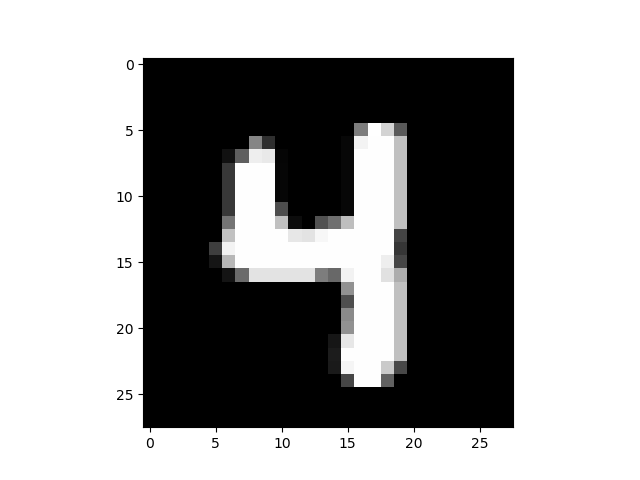

In [29]:
plt.figure()
plt.imshow(X_train[58].reshape((28,28)), cmap="gray")
plt.show()

In [21]:
# choose any image to want by specifying the index
img_to_visualize = X_train[58]
# Keras requires the image to be in 4D
# So we add an extra dimension to it.
img_to_visualize = np.expand_dims(img_to_visualize, axis=0)

def layer_to_visualize(layer, my_title):
    """
    compute the output of the convolutional and maxpool layers
    
    requires the use of particular backend flags to turn off
    training behavior
    """
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    # compute the convolutional output of the layer given
    # the input image
    # e.g. The first layer will take a 28x28 image and will use
    # a Convolution2D layer to pass a 3x3 kernel to create 32 filters
    # meaning 1 28x28x1 image becomes 32 26x26x1 images
    convolutions = convout1_f(img_to_visualize)
    # use the squeeze function dump the channel data
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    # technically this is "backward" from the original example
    # this is because we are using a slightly different API to
    # pass our images into the network
    n = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
#     for i in range(convolutions.shape[2]):
#         ax = fig.add_subplot(n,n,i+1)
#         ax.axis('off')
#         ax.imshow(convolutions[:,:,i], cmap='gray')
    for i in range(4):
        for j in range(8):
            try:
                img, loss = kept_filters[i * 8 + j]
                ax = fig.add_subplot(4,8,i * 8 + j + 1)
                ax.axis('off')
                ax.imshow(convolutions[:,:,i*8+j], cmap='gray')
            except:
                pass
    fig.suptitle(my_title, fontsize=24)

Shape of conv: (28, 28, 32)


<IPython.core.display.Javascript object>

Shape of conv: (28, 28, 32)


<IPython.core.display.Javascript object>


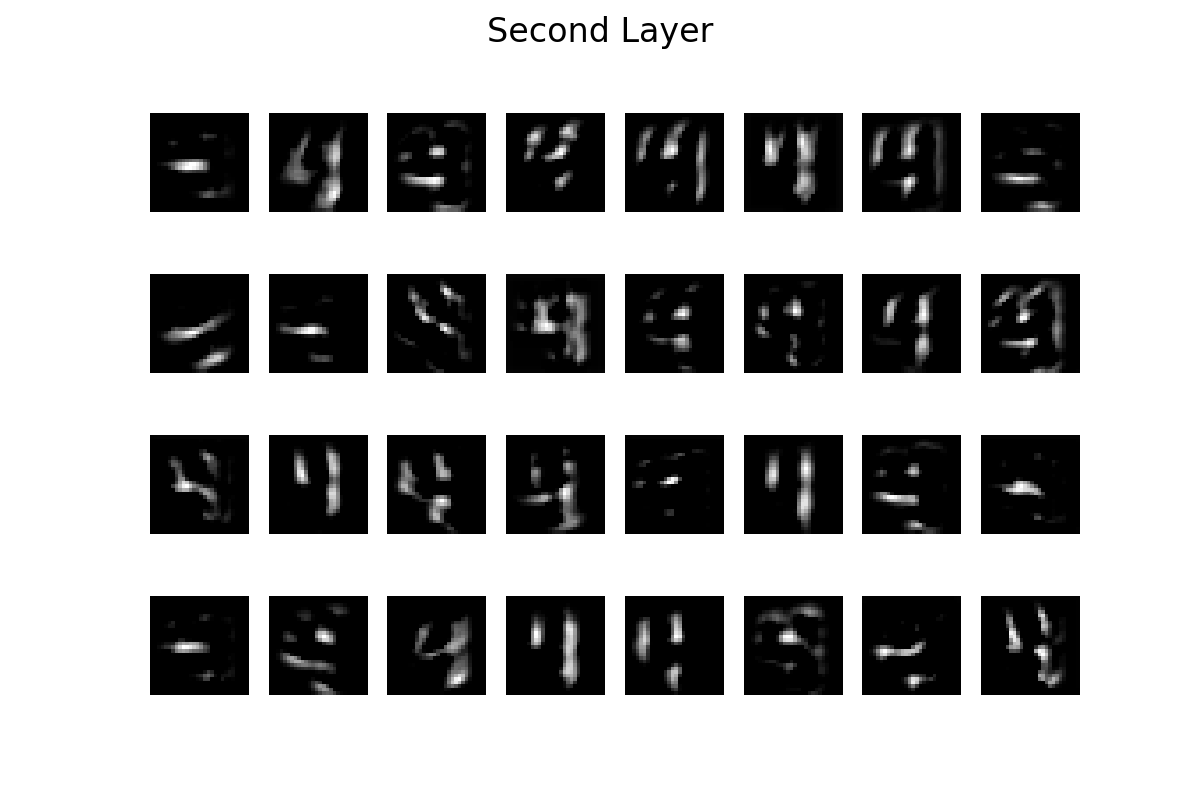

Shape of conv: (14, 14, 64)


<IPython.core.display.Javascript object>


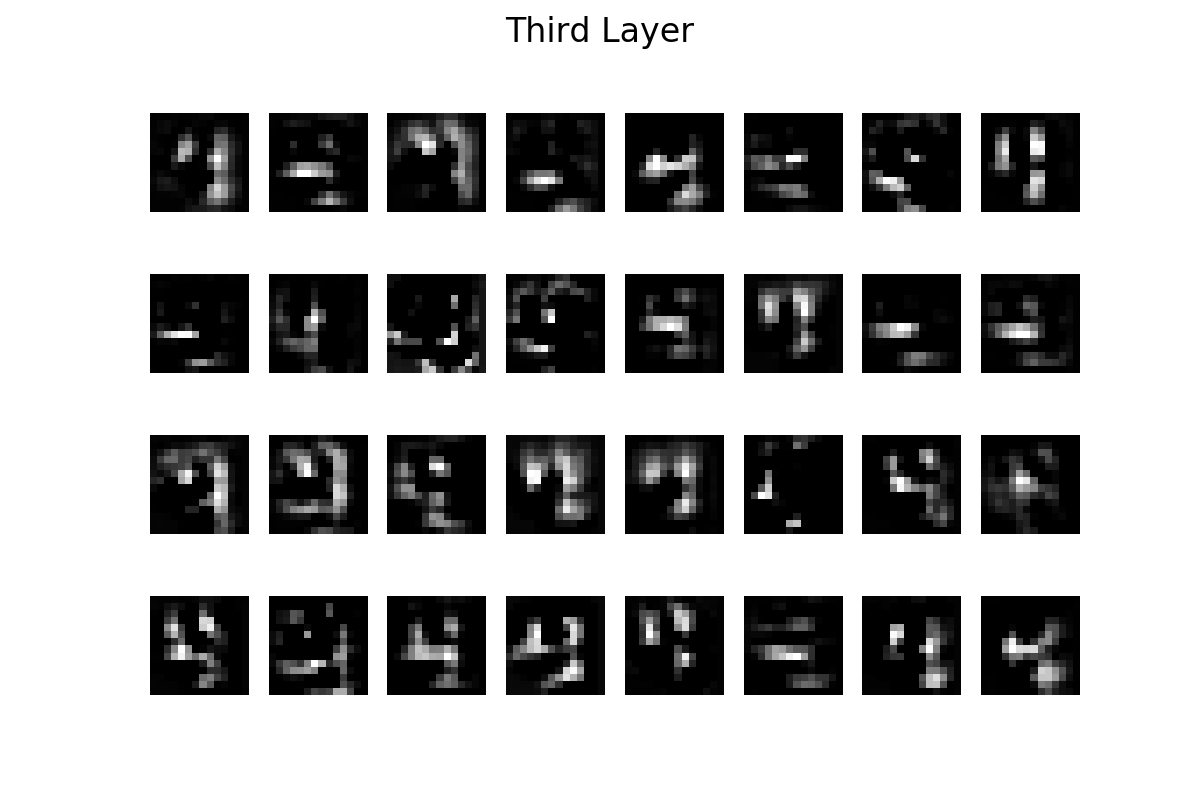

Shape of conv: (14, 14, 64)


<IPython.core.display.Javascript object>


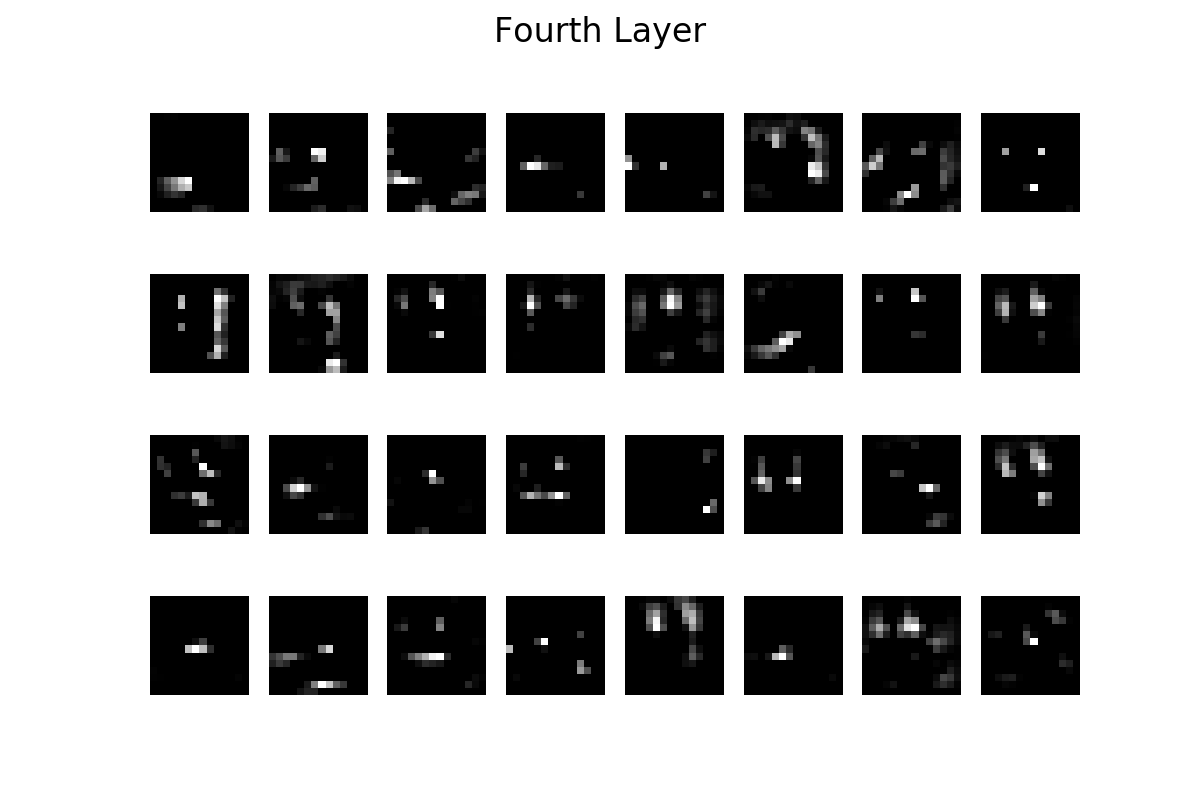

In [43]:
# Specify the layer to want to visualize
layer_to_visualize(convout1, "First Layer")

# # As convout2 is the result of a MaxPool2D layer
# # We can see that the image has blurred since
# # the resolution has reduced 
layer_to_visualize(convout2, "Second Layer")

layer_to_visualize(convout3, "Third Layer")

layer_to_visualize(convout4, "Fourth Layer")



In [44]:
print(y_train[58])
print(model.predict(np.expand_dims(X_train[58], axis=0)))
print(model.predict(np.expand_dims(X_train[58], axis=0)).argmax(axis=1))

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[[5.5456014e-15 4.0124486e-09 1.1152201e-09 7.3804997e-13 1.0000000e+00
  2.5844828e-12 8.9363569e-12 2.5656901e-09 2.3506169e-10 5.4295981e-09]]
[4]


# kernel visualization

https://blog.keras.io/category/demo.html

In [20]:
model = Sequential()

# note the padding argument here keeps the image size the same...and prevents the shrinking
# also note the larger kernel
model.add(Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
convout2 = Activation('relu')
model.add(convout2)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Convolution2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
convout3 = Activation('relu')
model.add(convout3)
model.add(Convolution2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
convout4 = Activation('relu')
model.add(convout4)
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, nb_epoch=10, validation_data=(X_test, y_test))

model.summary()

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 125us/step - loss: 0.2204 - acc: 0.9289 - val_loss: 0.0420 - val_acc: 0.9857
Epoch 2/10
60000/60000 [==============================] - 7s 117us/step - loss: 0.0632 - acc: 0.9808 - val_loss: 0.0320 - val_acc: 0.9890
Epoch 3/10
60000/60000 [==============================] - 7s 117us/step - loss: 0.0495 - acc: 0.9854 - val_loss: 0.0219 - val_acc: 0.9926
Epoch 4/10
60000/60000 [==============================] - 7s 115us/step - loss: 0.0404 - acc: 0.9879 - val_loss: 0.0212 - val_acc: 0.9925
Epoch 5/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.0342 - acc: 0.9899 - val_loss: 0.0212 - val_acc: 0.9931
Epoch 6/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.0309 - acc: 0.9907 - val_loss: 0.0187 - val_acc: 0.9935
Epoch 7/10
60000/60000 [==============================] - 7s 119us/step - loss: 0.0269 - acc: 0.9916 - val_loss: 0.0225 - 

(5, 5, 1, 32)


<IPython.core.display.Javascript object>


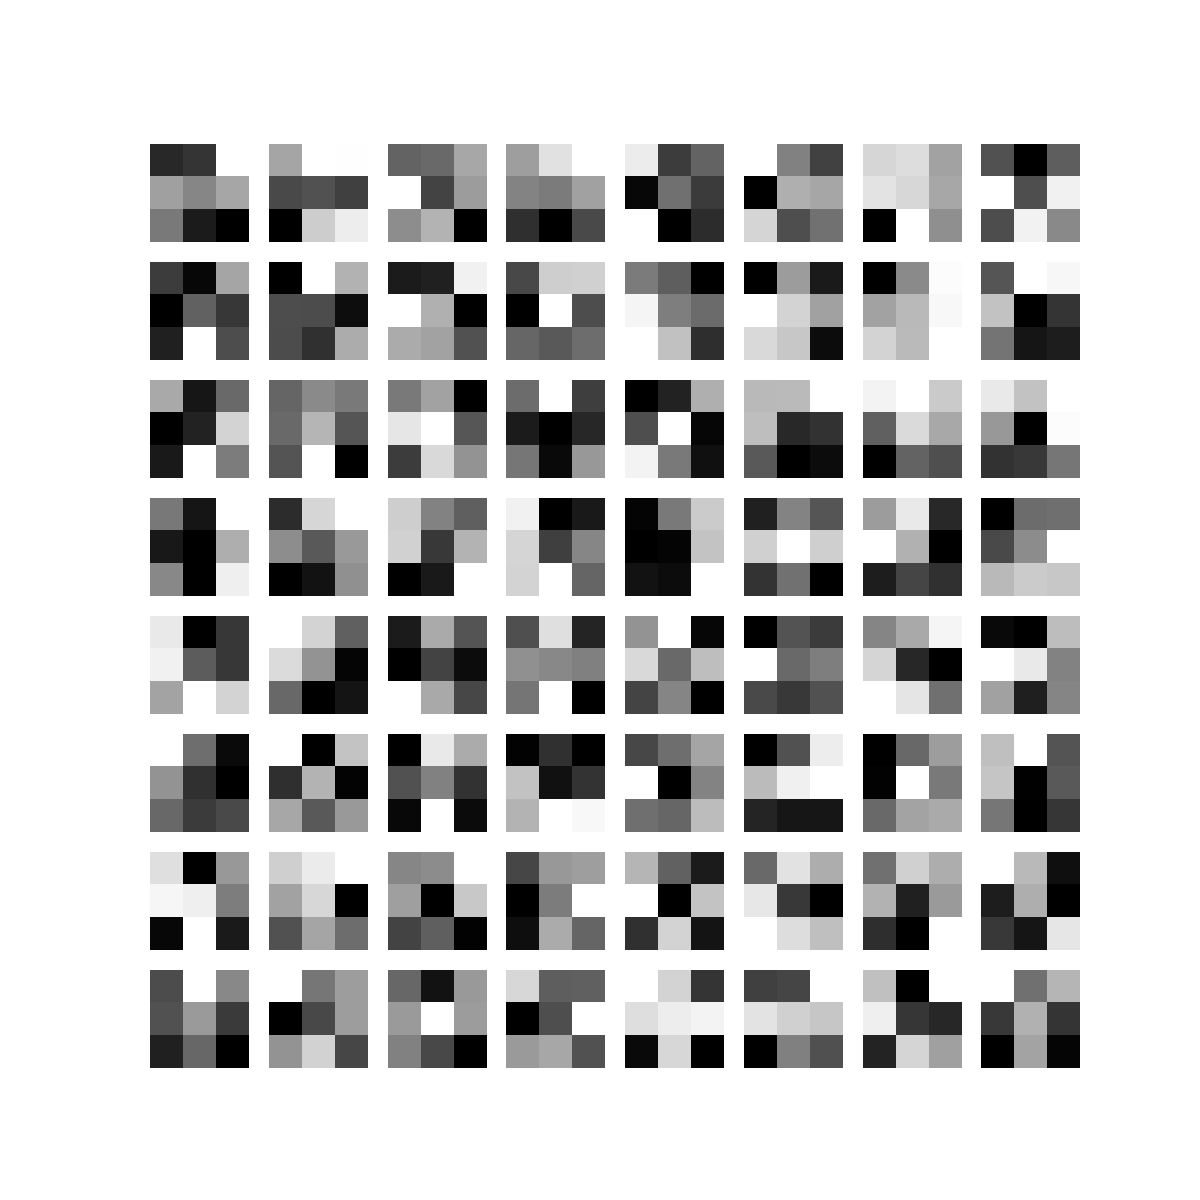

In [98]:
#get_weights [x, y, channel, nth convolutions layer ]
# print(len(model.layers))
# print(len(model.layers[0].get_weights()))
print(model.layers[0].get_weights()[0].shape)
weight_conv2d_1 = model.layers[8].get_weights()[0][:,:,0,:]
 
col_size = 8
row_size = 8
filter_index = 0
fig, ax = plt.subplots(row_size, col_size, figsize=(12,12))
for row in range(0,row_size): 
    for col in range(0,col_size):
        ax[row][col].imshow(weight_conv2d_1[:,:,filter_index],cmap="gray")
        ax[row][col].axis("off")
        filter_index += 1

## First Layer

In [56]:
import time
# dimensions of the generated pictures for each filter.
img_width = 28
img_height = 28

# the name of the layer we want to visualize
layer_name = 'conv2d_5'

# util function to convert a tensor into a valid image

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# # build the VGG16 network with ImageNet weights
# model = vgg16.VGG16(weights='imagenet', include_top=False)
# print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input
# input_img = np.expand_dims(X_train[1], axis=0)
# input_img *= 255
# input_img = input_img.astype('float')

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print(layer_dict.keys())


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    print(x)
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


kept_filters = []
for filter_index in range(32):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
#     layer_output = convout1.output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])
    loss = K.mean(layer_output[:, :, :, filter_index])
    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
#     if K.image_data_format() == 'channels_first':
#         input_img_data = np.random.random((1, 3, img_width, img_height))
#     else:
#         input_img_data = np.random.random((1, img_width, img_height, 3))
#     input_img_data = (input_img_data - 0.5) * 20 + 128
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 1))
    input_img_data = np.expand_dims(np.copy(X_train[58]), axis=0)
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
__________

Tensor("gradients_457/conv2d_5/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 12.031662
Current loss value: 12.186527
Current loss value: 12.341393
Current loss value: 12.496257
Current loss value: 12.651119
Current loss value: 12.8059845
Current loss value: 12.960849
Current loss value: 13.115713
Current loss value: 13.2705765
Current loss value: 13.42544
Current loss value: 13.580303
Current loss value: 13.7351675
Current loss value: 13.890032
Current loss value: 14.044894
Current loss value: 14.1997595
Current loss value: 14.354626
Current loss value: 14.509488
Current loss value: 14.664351
Current loss value: 14.819215
Current loss value: 14.974081
Filter 8 processed in 2s
Processing filter 9
Tensor("gradients_458/conv2d_5/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 1.735148
Current loss value: 1.8529898
Current loss value: 1.9708318
Current loss value: 2.0886734
Current loss va

Tensor("gradients_468/conv2d_5/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 11.488802
Current loss value: 11.700026
Current loss value: 11.911258
Current loss value: 12.122484
Current loss value: 12.333708
Current loss value: 12.544943
Current loss value: 12.756171
Current loss value: 12.967398
Current loss value: 13.178626
Current loss value: 13.390002
Current loss value: 13.602028
Current loss value: 13.814063
Current loss value: 14.0261
Current loss value: 14.238315
Current loss value: 14.451014
Current loss value: 14.664024
Current loss value: 14.877509
Current loss value: 15.090983
Current loss value: 15.30446
Current loss value: 15.51794
Filter 19 processed in 2s
Processing filter 20
Tensor("gradients_469/conv2d_5/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 3.2765326
Current loss value: 3.480998
Current loss value: 3.6902223
Current loss value: 3.9032702
Current loss value: 

Tensor("gradients_479/conv2d_5/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 12.596809
Current loss value: 12.7488785
Current loss value: 12.900949
Current loss value: 13.053024
Current loss value: 13.205095
Current loss value: 13.357165
Current loss value: 13.509237
Current loss value: 13.661309
Current loss value: 13.81338
Current loss value: 13.965451
Current loss value: 14.117524
Current loss value: 14.269596
Current loss value: 14.421668
Current loss value: 14.573735
Current loss value: 14.72581
Current loss value: 14.877881
Current loss value: 15.029953
Current loss value: 15.182027
Current loss value: 15.334094
Current loss value: 15.486168
Filter 30 processed in 2s
Processing filter 31
Tensor("gradients_480/conv2d_5/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 13.1098385
Current loss value: 13.252125
Current loss value: 13.394414
Current loss value: 13.536699
Current loss va

In [34]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 6

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
# kept_filters.sort(key=lambda x: x[1], reverse=True)
# kept_filters = kept_filters[:n * n]

# # build a black picture with enough space for
# # our 8 x 8 filters of size 128 x 128, with a 5px margin in between
# margin = 5
# width = n * img_width + (n - 1) * margin
# height = n * img_height + (n - 1) * margin
# stitched_filters = np.zeros((width, height, 3))

32


<IPython.core.display.Javascript object>


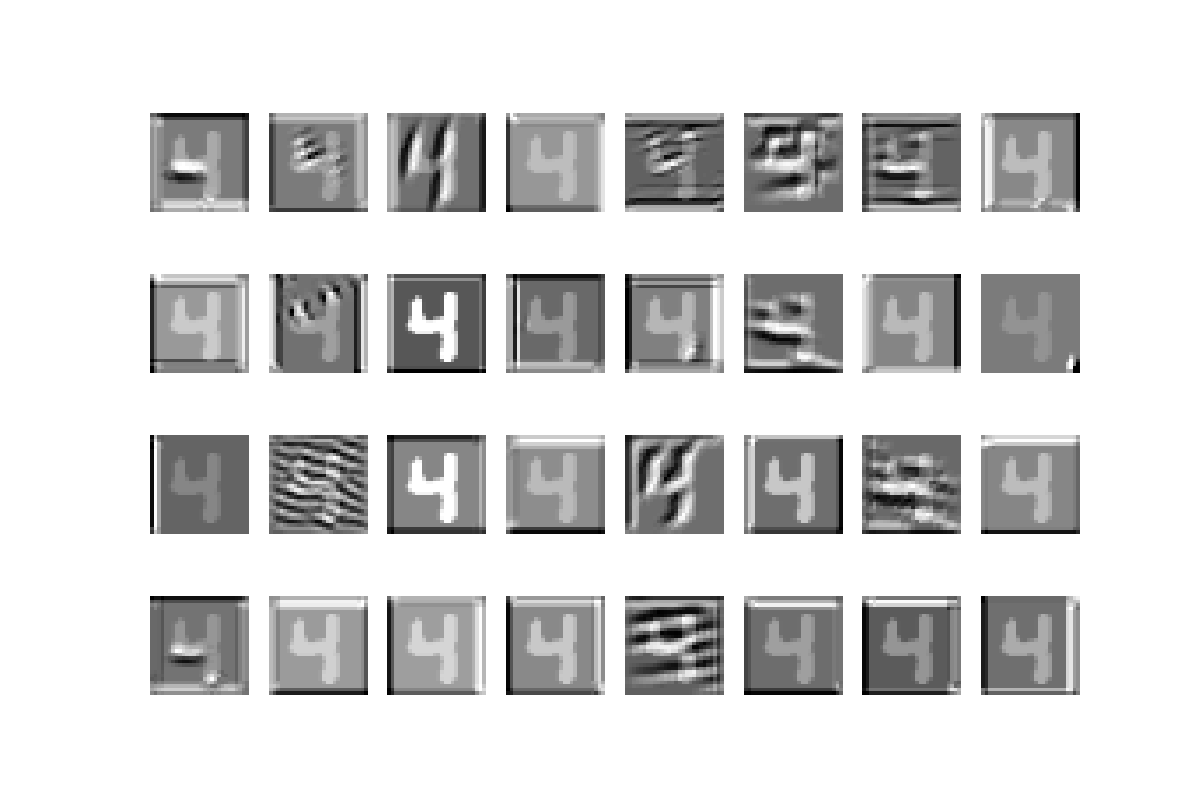

In [57]:
print(len(kept_filters))
# why is this 31 and not 32...oh well
# Visualization of each filter of the layer
fig = plt.figure(figsize=(12,8))
for i in range(4):
    for j in range(8):
        try:
            img, loss = kept_filters[i * 8 + j]
            ax = fig.add_subplot(4,8,i * 8 + j + 1)
            ax.axis('off')
            ax.imshow(img.reshape(28,28), cmap='gray')
        except:
            pass
# for i in range(convolutions.shape[2]):
#     ax = fig.add_subplot(n,n,i+1)
#     ax.imshow(convolutions[:,:,i], cmap='gray')

## Deepest Layer

In [61]:
import time
# dimensions of the generated pictures for each filter.
img_width = 28
img_height = 28

# the name of the layer we want to visualize
layer_name = 'conv2d_8'

# util function to convert a tensor into a valid image

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# # build the VGG16 network with ImageNet weights
# model = vgg16.VGG16(weights='imagenet', include_top=False)
# print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input
# input_img = np.expand_dims(X_train[1], axis=0)
# input_img *= 255
# input_img = input_img.astype('float')

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
print(layer_dict.keys())


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    print(x)
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


kept_filters = []
for filter_index in range(64):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
#     layer_output = convout1.output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])
#     loss = K.mean(layer_output[:, :, :, filter_index])
    loss = K.mean(model.output[:,5])
    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
#     if K.image_data_format() == 'channels_first':
#         input_img_data = np.random.random((1, 3, img_width, img_height))
#     else:
#         input_img_data = np.random.random((1, img_width, img_height, 3))
#     input_img_data = (input_img_data - 0.5) * 20 + 128
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 1))
#     input_img_data = np.expand_dims(np.copy(X_train[58]), axis=0)
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
#     if loss_value > 0:
#         img = deprocess_image(input_img_data[0])
#         kept_filters.append((img, loss_value))
    img = deprocess_image(input_img_data[0])
    kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
__________

KeyboardInterrupt: 

In [37]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 6

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
# kept_filters.sort(key=lambda x: x[1], reverse=True)
# kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

In [52]:
print(len(kept_filters))

64


<IPython.core.display.Javascript object>


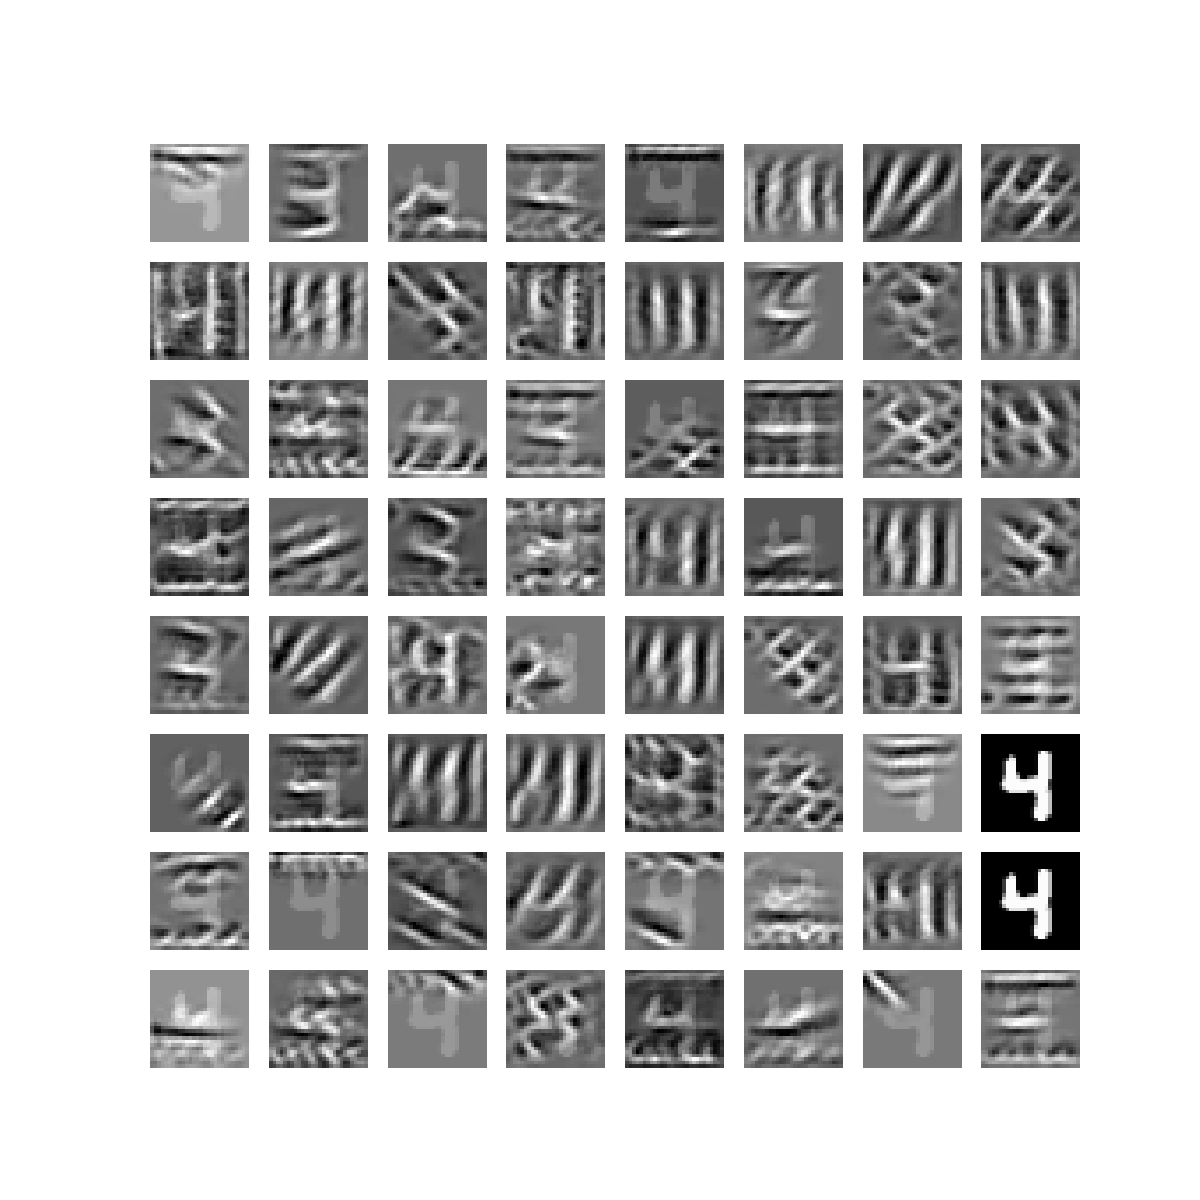

In [60]:
# Visualization of each filter of the layer
fig = plt.figure(figsize=(12,12))
n=8
for i in range(8):
    for j in range(8):
        img, loss = kept_filters[i * n + j]
        ax = fig.add_subplot(8,8,i * n + j + 1)
        ax.axis('off')
        ax.imshow(img.reshape(28,28), cmap='gray')
# for i in range(convolutions.shape[2]):
#     ax = fig.add_subplot(n,n,i+1)
#     ax.imshow(convolutions[:,:,i], cmap='gray')

Copied code from keras

In [79]:
import time
# dimensions of the generated pictures for each filter.
img_width = 28
img_height = 28

# util function to convert a tensor into a valid image

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# # build the VGG16 network with ImageNet weights
# model = vgg16.VGG16(weights='imagenet', include_top=False)
# print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input
# input_img = np.expand_dims(X_train[1], axis=0)
# input_img *= 255
# input_img = input_img.astype('float')

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    print(x)
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


kept_filters = []
print(model.output.shape)
loss = K.mean(model.output[:, 2])
# we compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads = normalize(grads)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

# step size for gradient ascent
step = 1.

# we start from a gray image with some random noise
#     if K.image_data_format() == 'channels_first':
#         input_img_data = np.random.random((1, 3, img_width, img_height))
#     else:
#         input_img_data = np.random.random((1, img_width, img_height, 3))
#     input_img_data = (input_img_data - 0.5) * 20 + 128
if K.image_data_format() == 'channels_first':
    input_img_data = np.random.random((1, 3, img_width, img_height))
else:
    input_img_data = np.random.random((1, img_width, img_height, 1))
#     input_img_data = np.expand_dims(np.copy(X_train[58]), axis=0)
input_img_data = (input_img_data - 0.5) * 20 + 128

# we run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

    print('Current loss value:', loss_value)
    if loss_value <= 0.:
        # some filters get stuck to 0, we can skip them
        break

# decode the resulting input image
#     if loss_value > 0:
#         img = deprocess_image(input_img_data[0])
#         kept_filters.append((img, loss_value))
img = deprocess_image(input_img_data[0])
kept_filters.append((img, loss_value))
end_time = time.time()
print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
__________

In [80]:
img, loss = kept_filters[0]
input_test = np.expand_dims(img, axis=0)
y_out = model.predict(input_test)
print(y_out)

[[0.000000e+00 0.000000e+00 1.000000e+00 1.792211e-23 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]]


<IPython.core.display.Javascript object>


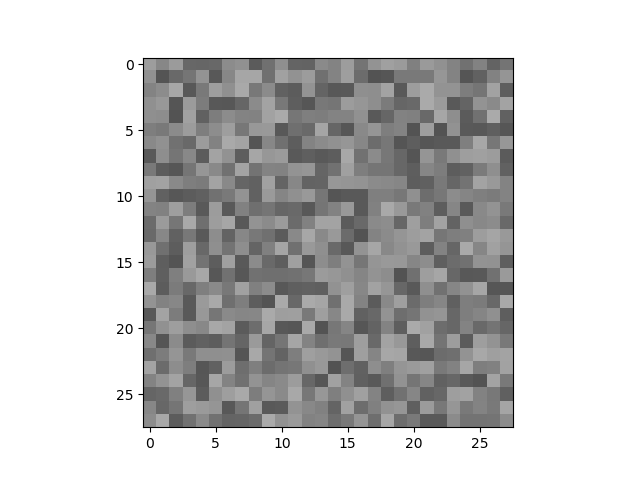

In [81]:
plt.figure()
img, loss = kept_filters[0]
plt.imshow(img.reshape((28,28)), vmin=0, vmax=255, cmap="gray")
plt.show()

In [ ]:
# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        width_margin = (img_width + margin) * i
        height_margin = (img_height + margin) * j
        stitched_filters[
            width_margin: width_margin + img_width,
            height_margin: height_margin + img_height, :] = img

In [ ]:
plt.figure()
plt.imshow(stitched_filters)

In [ ]:
from scipy.misc import imsave
# save the result to disk
save_img('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

## Original Visualization Example

[Link to original example](https://github.com/yashk2810/Visualization-of-Convolutional-Layers/blob/master/Visualizing%20Filters%20Python3%20Theano%20Backend.ipynb)

In [ ]:
# Model 
new_model = Sequential()

new_model.add(Convolution2D(32, (3, 3), input_shape=(28,28,1))) 
convout1 = Activation('relu')
new_model.add(convout1)
convout2 = MaxPooling2D()
new_model.add(convout2)

new_model.add(Flatten())

new_model.add(Dense(128))
new_model.add(Activation('relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(10))
new_model.add(Activation('softmax'))

new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
new_model.fit(X_train, y_train, batch_size=128, nb_epoch=5, validation_data=(X_test, y_test))

In [ ]:
# choose any image to want by specifying the index
img_to_visualize = X_train[1]
# Keras requires the image to be in 4D
# So we add an extra dimension to it.
img_to_visualize = np.expand_dims(img_to_visualize, axis=0)
print(img_to_visualize.shape)
# print(new_model.inputs)

def layer_to_visualize(layer):
    inputs = [K.learning_phase()] + new_model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img_to_visualize)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    n = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(convolutions.shape[2]):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[:,:,i], cmap='gray')

In [ ]:
# Specify the layer to want to visualize
layer_to_visualize(convout1)

# # As convout2 is the result of a MaxPool2D layer
# # We can see that the image has blurred since
# # the resolution has reduced 
layer_to_visualize(convout2)

